# Predicting saving behavior with demographic characteristics, psychological characteristics, and situational factors using machine learning models

### Student: Vitali Tsentsiper
### Supervisor: Guy Hochman
### Institution: Reichman University (IDC), M.A Behavioral Economics

## <u>Table of Content</u> <a class="anchor" id="toc"></a>


* [Part I - Loading the data](#part_I)

* [Part II - Exploratory Data Analysis](#part_II)

* [Part III - Preproccessing](#part_III)

* [Part IV - Models](#part_IV)
 * [Predict 7 classes](#part_IV_7)
 * [Predict 3 classes - Low, Mid, High](#part_IV_3)
 * [Regression 7 and 3 classes](#part_IV_reg)

## Import libraries

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import miceforest as mf
import re

#EDA 
import sidetable
import missingno as msno
import shap
from yellowbrick.classifier import ROCAUC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize
from sklearn.impute import KNNImputer
from sklearn.metrics import auc

#ML
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier 
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import RandomOverSampler
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

#Metrics classification
from sklearn.metrics import f1_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import metrics

#Regression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

#Metrics regression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

#ELI5
from eli5 import show_weights
from eli5.sklearn import PermutationImportance
from eli5 import show_prediction

# # Import the LimeTabularExplainer module
from lime.lime_tabular import LimeTabularExplainer

#PDP
from sklearn.inspection import PartialDependenceDisplay

#Error ignore
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

C:\Users\vital\anaconda3\envs\tesorFlow-sessions\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Define Functions

In [2]:
#Function that gets model, feature and target and plot precision recall curve
def pr_curve(model, features, target):
    y_pred_proba = model.predict_proba(features)
    
    Y = label_binarize(target, classes=[1, 2, 3, 4 ,5, 6, 7])
    
    n_classes = len(set(target))

    # precision recall curve
    precision = dict()
    recall = dict()
    plt.figure(figsize = (15,8))
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(Y[:, i], y_pred_proba[:, i])
        plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(i))

    plt.xlabel("recall", size=15)
    plt.ylabel("precision", size=15)
    plt.legend(['0','$1-99','$100-999','$1,000-4,999','$5,000-19,999','$20,000-74,999','$75,000 or more'], loc="best")
    plt.title("precision vs. recall curve", size=20)
    plt.show()

In [3]:
#Visualization function for ROC AUC
def plot_ROC_curve(model, xtrain, ytrain, xtest, ytest):

    # Creating visualization with the readable labels
    visualizer = ROCAUC(model, encoder={1: '$0', 
                                        2: '$1-99', 
                                        3: '$100-999',
                                        4: '$1,000-4,999',
                                        5: '$5,000-19,999',
                                        6: '$20,000-74,999',
                                        7: '$75,000 or more'})
    
                                        
    # Fitting to the training data first then scoring with the test data                                    
    visualizer.fit(xtrain, ytrain)
    visualizer.score(xtest, ytest)
    visualizer.show()
    
    return visualizer

In [4]:
#Visualization function for ROC AUC for 3 classes
def plot_ROC_curve_3(model, xtrain, ytrain, xtest, ytest):

    # Creating visualization with the readable labels
    visualizer = ROCAUC(model, encoder={1: 'Low', 
                                        2: 'Mid', 
                                        3: 'High'})
    
                                        
    # Fitting to the training data first then scoring with the test data                                    
    visualizer.fit(xtrain, ytrain)
    visualizer.score(xtest, ytest)
    visualizer.show()
    
    return visualizer

In [5]:
#Function that gets the pipeline, the parameters for pipeline and from GridSearcgCV, features train and target train
#and prints the best parameters, the best score and returns the best fitted model

def best_model(pipeline, parm, x_train, y_train):
    model_grid = GridSearchCV(pipeline, parm, cv=5, verbose=5, refit=True, scoring = 'f1_weighted',return_train_score=True)
    model_grid.fit(x_train, y_train)
    print()
    print('Best parameters:', model_grid.best_params_)
    print()
    print('Best score:', round(model_grid.best_score_,2))
    return model_grid

In [6]:
#Function that gets the pipeline, the parameters for pipeline and from GridSearcgCV, features train and target train
#and prints the best parameters, the best score and returns the best fitted model - bianry for each class

def best_model_binary(pipeline, parm, x_train, y_train):
    model_grid = GridSearchCV(pipeline, parm, cv=5, verbose=5, refit=True, scoring = 'f1',return_train_score=True)
    model_grid.fit(x_train, y_train)
    print()
    print('Best parameters:', model_grid.best_params_)
    print()
    print('Best score:', round(model_grid.best_score_,2))
    return model_grid

In [7]:
#Function that gets the pipeline, the parameters for pipeline and from GridSearcgCV, features train and target train
#and prints the best parameters, the best score and returns the best fitted model - regression

def best_model_regression(pipeline, parm, x_train, y_train):
    model_grid = GridSearchCV(pipeline, parm, cv=5, verbose=5, refit=True, scoring = 'neg_mean_absolute_error',return_train_score=True)
    model_grid.fit(x_train, y_train)
    print()
    print('Best parameters:', model_grid.best_params_)
    print()
    print('Best score:', abs(round(model_grid.best_score_,2)))
    return model_grid

## <u>Part I - Loading the data</u> <a class="anchor" id="part_I"></a>

[Table of content](#toc)

## Workplan

1. Load original dataset
2. Remove features which might create data leakedge and replace their names to meaningful names
4. Replace non answered questions with NaN
3. Remove unvalid target variables
6. Check for corerlations between features and remove highly correlated features
3. Split the data into train and test sets
5. Impute missing values - KNN, MICE and manual

In [8]:
original_data = pd.read_csv('C:/My files/Thesis/Data sets/1 - Financial survey/1 - NFWBS_PUF_2016_data.csv')

In [9]:
#See the data
original_data.head()

PUF_ID  sample  fpl  SWB_1  SWB_2  SWB_3  FWBscore  FWB1_1  FWB1_2  FWB1_3  \
0   10350       2    3      5      5      6        55       3       3       3   
1    7740       1    3      6      6      6        51       2       2       3   
2   13699       1    3      4      3      4        49       3       3       3   
3    7267       1    3      6      6      6        49       3       3       3   
4    7375       1    3      4      4      4        49       3       3       3   

   ...  PPMSACAT  PPREG4  PPREG9  PPT01  PPT25  PPT612  PPT1317  PPT18OV  \
0  ...         1       4       8      0      0       0        0        1   
1  ...         1       2       3      0      0       0        0        2   
2  ...         1       4       9      0      0       0        1        2   
3  ...         1       3       7      0      0       0        0        1   
4  ...         1       2       4      0      0       1        0        4   

   PCTLT200FPL   finalwt  
0            0  0.367292  
1            0  1.327561  
2            1  0.835156  
3            0  1.410871  
4            1  4.260668  

[5 rows x 217 columns]

In [10]:
#Data size
original_data.shape

(6394, 217)

In [11]:
#Upload file with the columns we want to keep and meaningful names 
col_names = pd.read_csv('C:/My files/Thesis/Data sets/1 - Financial survey/columns for ML updated.csv', encoding='cp1252')

In [12]:
col_names.head()

Variable Name                                   Variables for ML
0         SWB_1                        I am satisfied with my life
1         SWB_2                    I am optimistic about my future
2         SWB_3  If I work hard today, I will be more successfu...
3        FWB2_4                        My finances control my life
4         FS1_1  I know how to get myself to follow through on ...

In [13]:
#Make list of used variables - original names
variables = list(col_names['Variable Name'])

In [15]:
#Make list of used meaningful names
names = list(col_names['Variables for ML'])

In [14]:
#Keep only wanted features, without data leakege
data_upd = original_data[variables]

In [16]:
#Create dictinary
col_rename_dict = {i:j for i,j in zip(variables,names)}

#Update names
data_upd = data_upd.rename(columns=col_rename_dict)

In [17]:
data_upd.head()

I am satisfied with my life  I am optimistic about my future  \
0                            5                                5   
1                            6                                6   
2                            4                                3   
3                            6                                6   
4                            4                                4   

   If I work hard today, I will be more successful in the future  \
0                                                  6               
1                                                  6               
2                                                  4               
3                                                  6               
4                                                  4               

   My finances control my life  \
0                            4   
1                            3   
2                            3   
3                            3   
4                            3   

   I know how to get myself to follow through on my financial intentions  \
0                                                  3                       
1                                                  3                       
2                                                  3                       
3                                                  3                       
4                                                  3                       

   I know where to find the advice I need to make decisions involving money  \
0                                                  3                          
1                                                  3                          
2                                                  3                          
3                                                  3                          
4                                                  3                          

   I know how to make complex financial decisions  \
0                                               4   
1                                               3   
2                                               3   
3                                               3   
4                                               3   

   I am able to make good financial decisions that are new to me  \
0                                                  3               
1                                                  3               
2                                                  3               
3                                                  3               
4                                                  3               

   I am able to recognize a good financial investment  \
0                                                  3    
1                                                  4    
2                                                  3    
3                                                  3    
4                                                  3    

   I know how to keep myself from spending too much  ...  Household Size  \
0                                                 3  ...               1   
1                                                 3  ...               2   
2                                                 3  ...               3   
3                                                 3  ...               1   
4                                                 3  ...               5   

   Household Income  Marital Status  Census Region  Census Division  \
0                 7               3              4                8   
1                 6               3              2                3   
2                 6               3              4                9   
3                 8               3              3                7   
4                 7               1              2                4   

   Presence of Household Members - Children 0-1  \
0                                             0 

## <u>Part II - Exploratory Data Analysis</u> <a class="anchor" id="part_II"></a>

[Table of content](#toc)

EDA - Exploratory data analysis to recognize patterns and see trends. As we are not trying to find causality we won't be able to say whether change in savings is due to financial behavior, or larger amount of savings enables better financial behavior. We are relying on literature to understand this behavior.

In [18]:
# Change "How much money do you have in savings today...?" to "target"
data_upd.rename(columns={'How much money do you have in savings today...?': 'target'},inplace=True)

In [19]:
#See what values we see in the target variables
data_upd['target'].value_counts()

 5     1093
 99     988
 4      931
 6      845
 7      834
 3      682
 1      440
 2      385
 98     158
-1       38
Name: target, dtype: int64

Interpretation of values

99 Prefer not to say<br>
98 I don't know<br>
-1 Refused<br>
-2 Question not asked because respondent not in item base<br>
-3 Invalid response<br>
-4 Response not written to database<br>
-5 County not known<br>

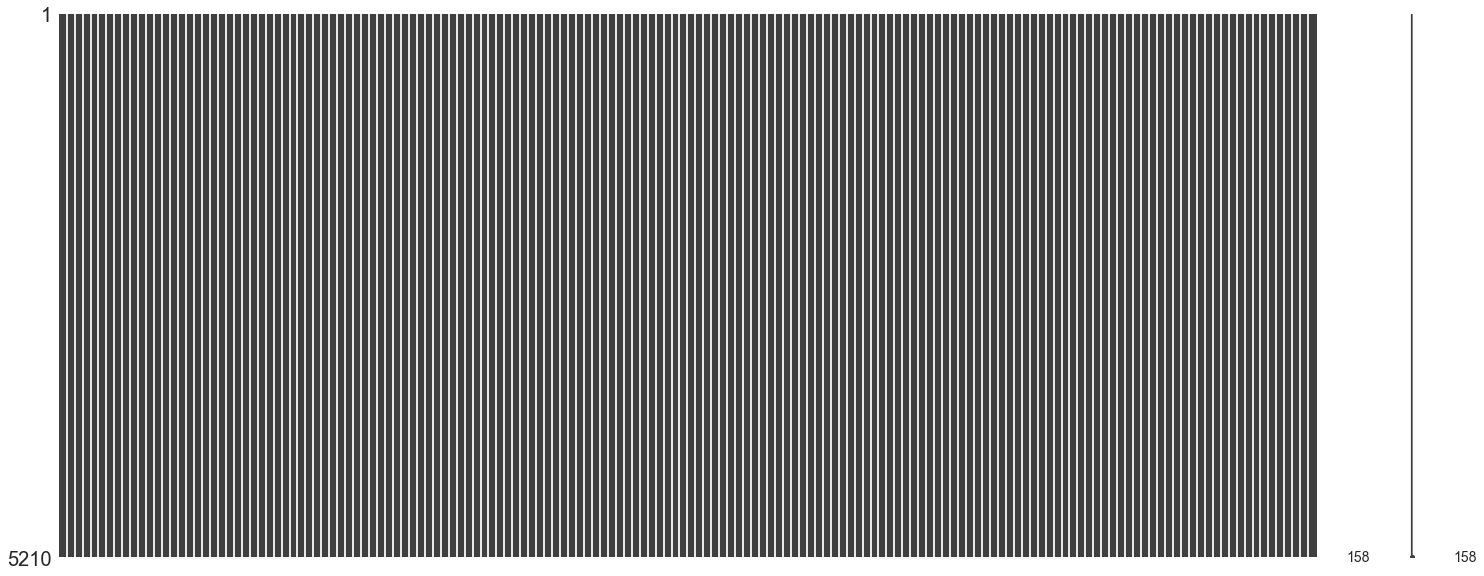

In [20]:
#Replace the unwanted answers in target with NaN
data_upd['target'] = data_upd['target'].replace([99,98,-1,-2, -3,-4,-5], np.nan)

#Drop NaN in target
data_final = data_upd.dropna(subset=['target'])


#See missing values
msno.matrix(data_final);

No missing values at the data - there are values such as I don't know, I don't want to answer etc.

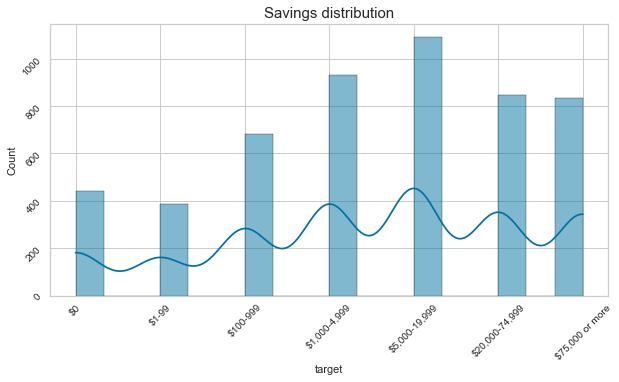

In [22]:
#See target distribution

fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(data_upd['target'], kde=True, ax=ax)
ax.set_xticks(range(1,8))
ax.set_xticklabels(['$0','$1-99','$100-999','$1,000-4,999','$5,000-19,999','$20,000-74,999','$75,000 or more'])
ax.tick_params(rotation=45)
plt.title('Savings distribution', size=15)
plt.show()

### Income

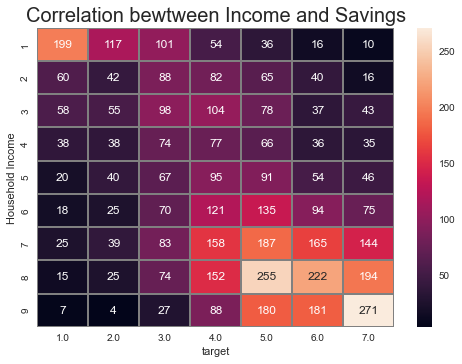

In [23]:
sns.heatmap(data_upd.groupby(['Household Income','target'])['target'].count().unstack(),
            linewidths=.01,linecolor='gray',annot=True,fmt='g')
           
plt.title('Correlation bewtween Income and Savings', size=20)
plt.show()

We see clear patternt between households income and savings amounts.

### Age

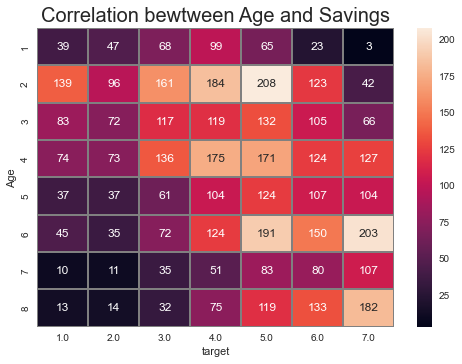

In [24]:
sns.heatmap(data_upd.groupby(['Age','target'])['target'].count().unstack(),
            linewidths=.01,linecolor='gray',annot=True,fmt='g')
           
plt.title('Correlation bewtween Age and Savings', size=20)
plt.show()

Age is much less correlated with savings, but we can see some wide trend

###  Planning horizon

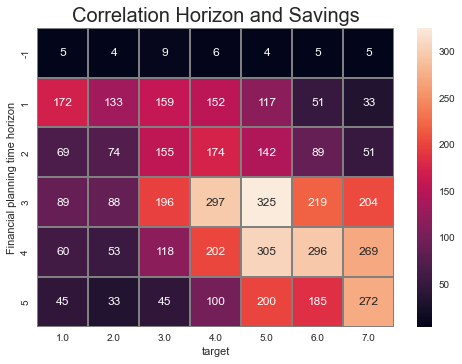

In [26]:
sns.heatmap(data_upd.groupby(['Financial planning time horizon','target'])['target'].count().unstack(),
            linewidths=.01,linecolor='gray',annot=True,fmt='g')
           
plt.title('Correlation Horizon and Savings', size=20)
plt.show()

Also here we see the paternt of higher horizon correlated with higher savings.

### Income volatility (uncertainity)

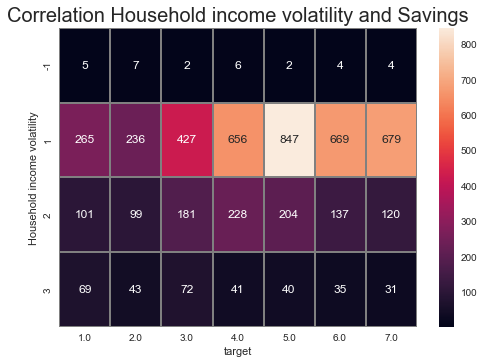

In [27]:
sns.heatmap(data_upd.groupby(['Household income volatility','target'])['target'].count().unstack(),
            linewidths=.01,linecolor='gray',annot=True,fmt='g')
           
plt.title('Correlation Household income volatility and Savings', size=20)
plt.show()

We see that most of the participents have low volaitlity in their income, but it seems that people with high volatility have less savings.

### Materialism

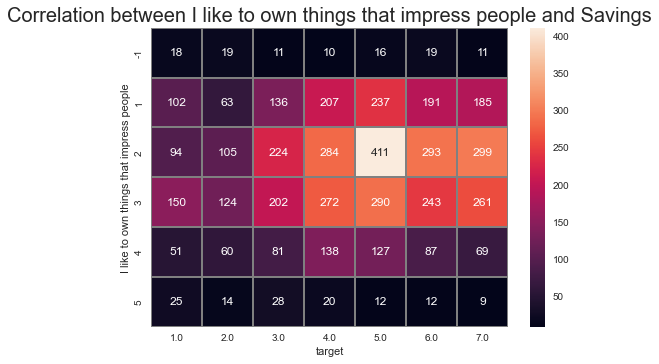

In [28]:
sns.heatmap(data_upd.groupby(['I like to own things that impress people','target'])['target'].count().unstack(),
            linewidths=.01,linecolor='gray',annot=True,fmt='g')
           
plt.title('Correlation between I like to own things that impress people and Savings', size=20)
plt.show()

We see that people who are strongly agree with this statment ("I like to own things that impress people") have less savings.

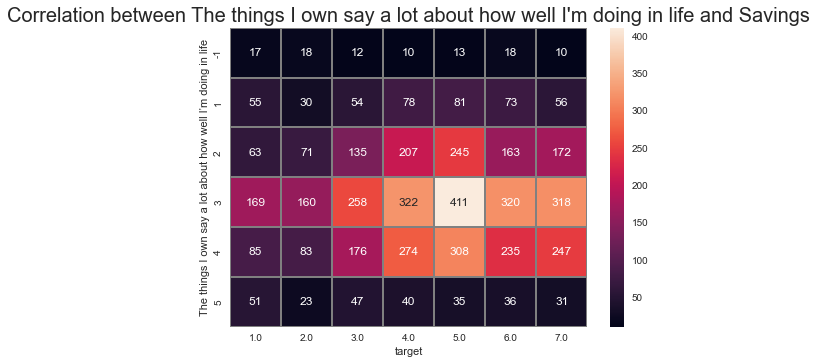

In [29]:
sns.heatmap(data_upd.groupby(["The things I own say a lot about how well I’m doing in life",'target'])['target'].count().unstack(),
            linewidths=.01,linecolor='gray',annot=True,fmt='g')
           
plt.title("Correlation between The things I own say a lot about how well I'm doing in life and Savings", size=20)
plt.show()

Also here, people who strongly agree with materialism have less savings. People who somehow agree, tend to have more savings.

### Locus of control

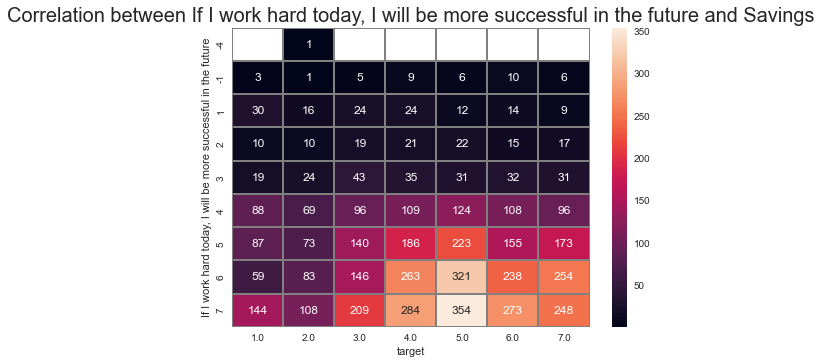

In [30]:
sns.heatmap(data_upd.groupby(["If I work hard today, I will be more successful in the future",'target'])['target'].count().unstack(),
            linewidths=.01,linecolor='gray',annot=True,fmt='g')
           
plt.title("Correlation between If I work hard today, I will be more successful in the future and Savings", size=20)
plt.show()

We see high correlation between people who belive in their hard work and savings amount.

### Unemployment situation

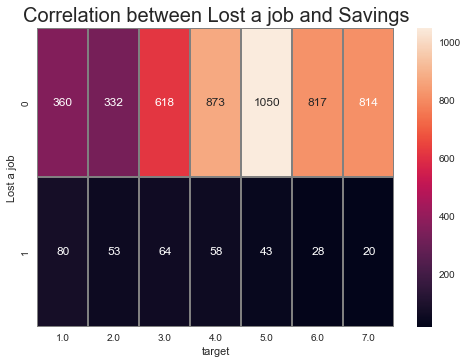

In [31]:
sns.heatmap(data_upd.groupby(["Lost a job",'target'])['target'].count().unstack(),
            linewidths=.01,linecolor='gray',annot=True,fmt='g')
           
plt.title("Correlation between Lost a job and Savings", size=20)
plt.show()

We see that people who had unemployment shock in the last year have less savings, although they are small portion of the sample.

### Psychological connectedness

**The question:** Please think about the important characteristics that make you the person you are now – your personality, temperament, major likes and dislikes, beliefs, values, ambitions, life goals, and ideals – and please rate the degree of connectedness between the person you expect to be in 5 years compared to the person you are now, where 0 means “I will be completely different in the future” and 100 means “I will be exactly the same in the future.”

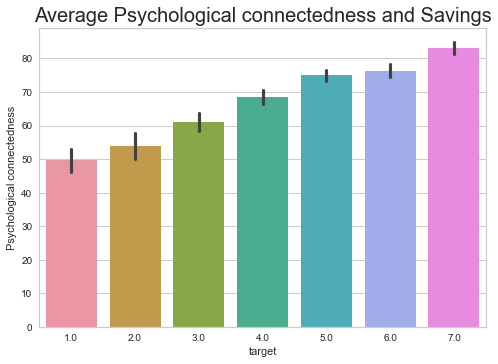

In [32]:
sns.barplot(data = data_upd, x = 'target', y = 'Psychological connectedness')

plt.title("Average Psychological connectedness and Savings", size=20)
plt.show()


**Conclusion:** We see connection between the savings amount to the extent people believe they will stay the same. As the situation is better people belive it will lest, as the situation is worst, people believe they will change.

# Correlation checks

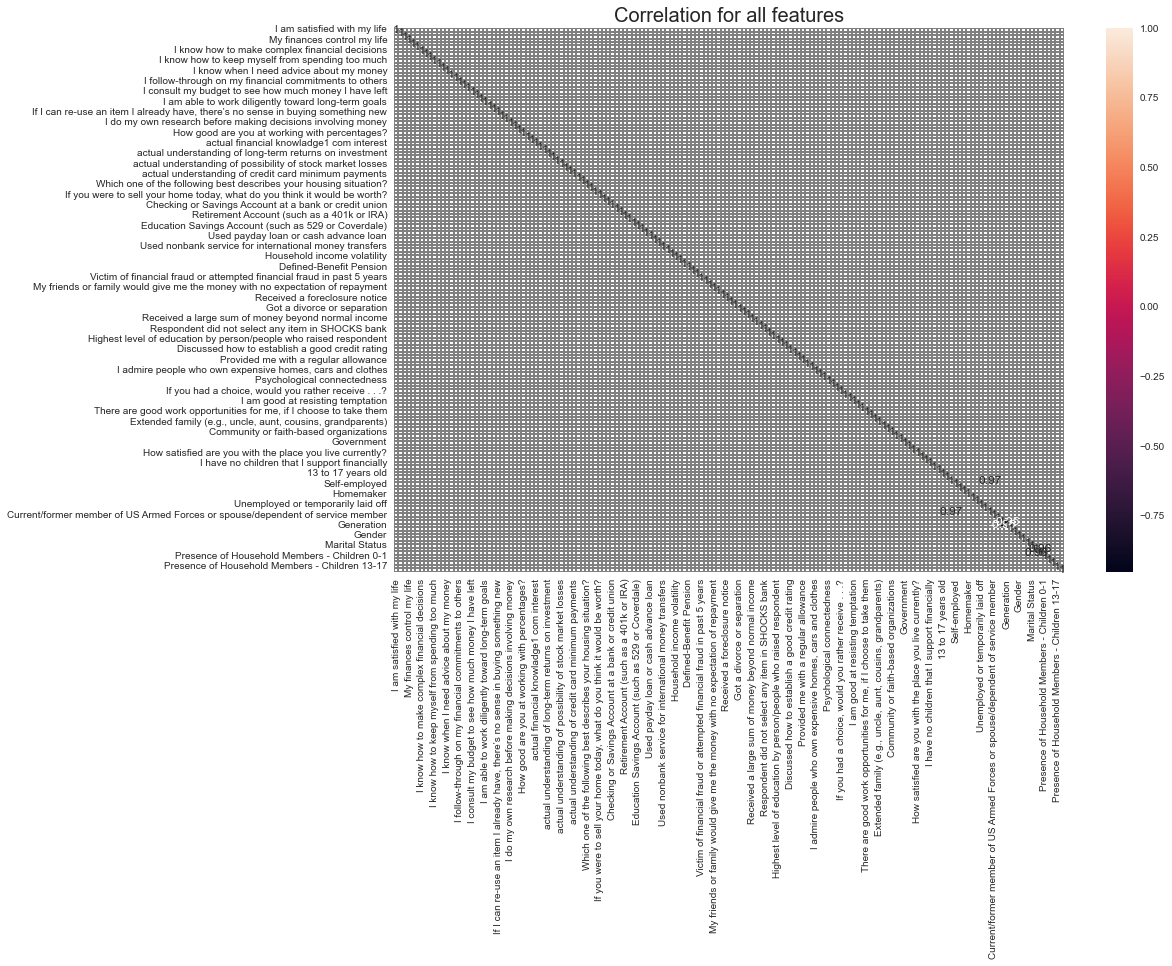

In [33]:
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(data_final.corr()[(data_final.corr()>0.9) | (data_final.corr()<-0.9)], ax=ax, 
            linewidths=.01,linecolor='gray',annot=True)
plt.title('Correlation for all features', size=20)
plt.show()

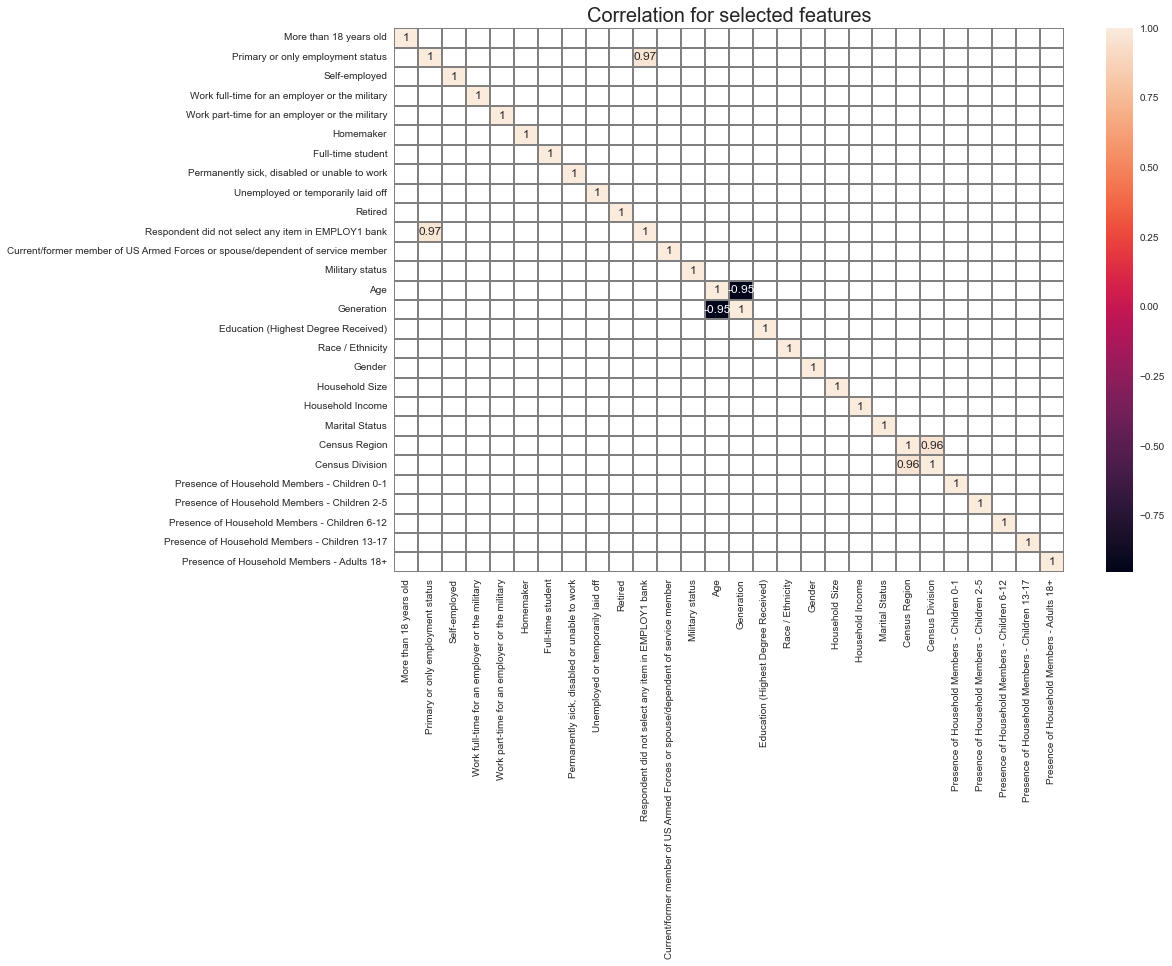

In [34]:
#Zoom in
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(data_final[data_final.columns[130:162]].corr()[(data_final[data_final.columns[130:162]].corr()>0.9) | (data_final[data_final.columns[130:162]].corr()<-0.9)], ax=ax, 
            linewidths=.01,linecolor='gray',annot=True)
plt.title('Correlation for selected features', size=20)
plt.show()

We see high correlation between:<br>
1. Work status not reported and Primary or only employment status: 97%. Work status are question asked and recorded as dummy variables which are later converted into new columns - Primary or only employment status. Work status questions should be removed.
2. Age and Generation: -95%. Age categories are represented by generation. We can remove this column without loosing any new infornation.
3. Census region and census division 96%. Division is more elaborated variable. Census region should be removed.

In [35]:
#Remove correlated file
data_final.drop(['Primary or only employment status','Self-employed','Work full-time for an employer or the military',
                 'Work part-time for an employer or the military','Homemaker','Full-time student',
                'Permanently sick, disabled or unable to work','Unemployed or temporarily laid off',
                'Retired','Respondent did not select any item in EMPLOY1 bank','Generation', 'Census Region'], axis=1, inplace=True)

# <u>Part III - Preproccessing</u>  <a class="anchor" id="part_III"></a>

[Table of content](#toc)

## Replace unanswered values with NaN

We tried to run models using the answers such as Prefer not to say, I don't know etc., as we thought it would add important inforamtion, but the results were worst, so we will replace all these answers with NaN values and fill them with MICE and manuel replacment.

In [36]:
#Replace answers with None values:

#99 Prefer not to say
#98 I don't know
#-1 Refused
#-2 Question not asked because respondent not in item base
#-3 Invalid response
#-4 Response not written to database
#-5 County not known
data_final = data_final.replace([99,98,-1,-2, -3,-4,-5], np.nan)

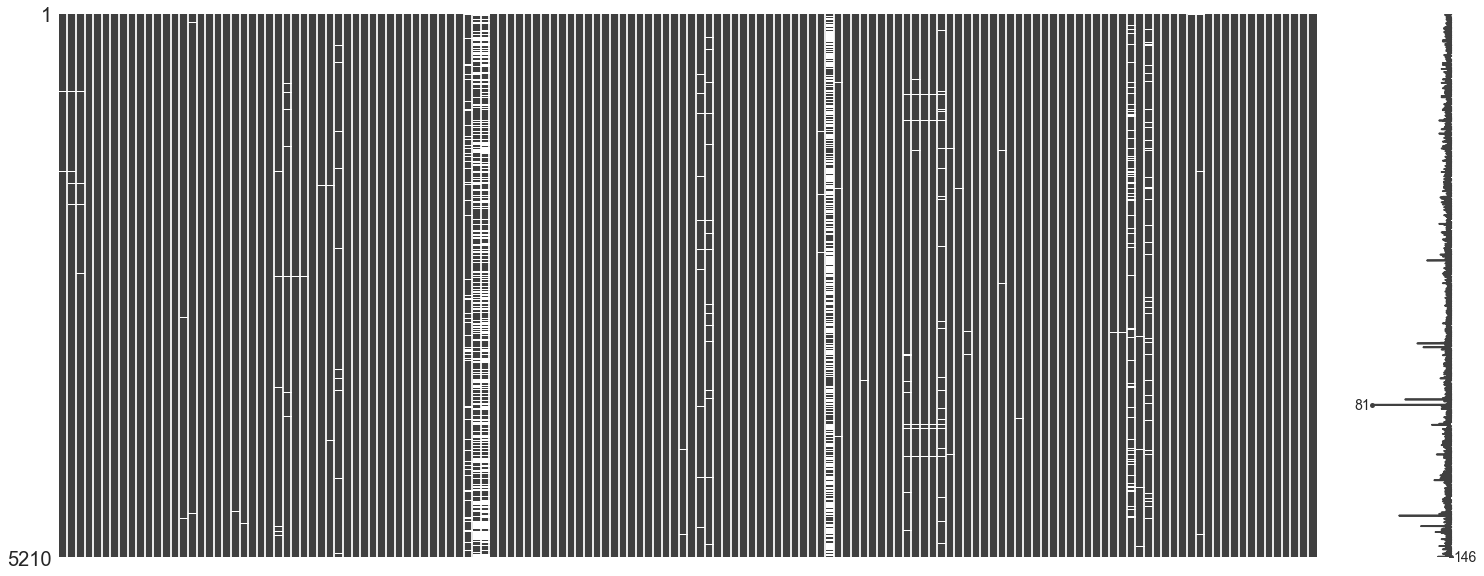

In [37]:
#See missing values
msno.matrix(data_final);

In [38]:
#Check for missing values
data_final.stb.missing(style=True)

As we have many missing values and many columns, we will zoom into the main columns to understand how to complete them.

**Missing completely at Random (MCAR):** The probability for missing observation is the same for all.<br><br>
**Missing not at random (MNAR):** There is a reason for the missing values which is related to other observation in the data or any missing value. <br><br>
**Missing at random (MAR):** there is a reason for the missing data which is related to other missing data.

### Consulting feature - Do you pay the person who helps take care of money matters in your household? 

In [41]:
data_upd['Do you pay the person who helps take care of money matters in your household?'].value_counts(normalize=True)

-2    0.517673
 0    0.447764
 1    0.033782
-1    0.000782
Name: Do you pay the person who helps take care of money matters in your household?, dtype: float64

For consulting, we see this question wasn't asked for people who answered that they are the one who are managing their own finances, and not somebody else. This means they are of cource not paying for consulting. We will complete this data with 0: Do you pay the person who helps take care of money matters in your household? No.

In [42]:
#Consulting - fill missing values with 0
data_final['Do you pay the person who helps take care of money matters in your household?'].fillna(0, inplace=True)

### Mortgage feature - What do you owe on your home today?

In [43]:
data_upd['What do you owe on your home today?'].value_counts(normalize=True)

-2     0.348764
 1     0.236472
 2     0.212856
 3     0.097279
 99    0.077886
 98    0.017986
-1     0.008758
Name: What do you owe on your home today?, dtype: float64

For mortgage amount, we see this question wasn't asked for most of the participants when wasn't relevant, but some didn't know or prefered not to asnwer. For these people we will complete the missing value with 1.
What do you owe on your home today? 1. Less than $50,000. because this also means 0, no mortgage.

In [44]:
#Mortgage - fill missing values with 1
data_final['What do you owe on your home today?'].fillna(1, inplace=True)

### Home value feature - If you were to sell your home today, what do you think it would be worth?

In [45]:
data_upd['If you were to sell your home today, what do you think it would be worth?'].value_counts(normalize=True)

-2     0.348764
 2     0.164686
 1     0.161871
 3     0.154989
 4     0.125743
 99    0.024867
 98    0.017986
-1     0.001095
Name: If you were to sell your home today, what do you think it would be worth?, dtype: float64

For home value, we see this question wasn't asked for most of the participants when wasn't relevant, but some didn't know or prefered not to asnwer.
For this question we will use the imputer as the value of the house people live in, regardless of owning the house, will indicate about their financial capabilities.

In [46]:
#Check for missing values after manual filling
data_final.stb.missing(style=True)

# Split the data into train test

In [49]:
# To use MICE we will add _ to all names

#Remove all spaces and signs in the column names to be able process the data
data_final = data_final.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '_', x))

In [50]:
target = data_final['target']
features = data_final.drop(['target'], axis=1)

#split into 80% (will be used with cross validation) train and 20% test
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.2, random_state=42)

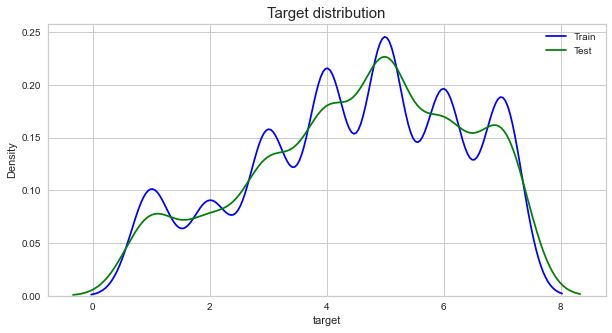

In [51]:
#See target distribution between groups

fig, axs = plt.subplots(figsize=(10, 5))
sns.kdeplot(data=target_train, ax=axs, color='blue', label='Train')
sns.kdeplot(data=target_test, ax=axs, color='green', label='Test')
plt.title('Target distribution', size=15)
plt.legend()
plt.show()

In [53]:
features_train.head()

I_am_satisfied_with_my_life  I_am_optimistic_about_my_future  \
5085                          7.0                              7.0   
1080                          5.0                              5.0   
3873                          6.0                              6.0   
55                            6.0                              6.0   
2057                          6.0                              6.0   

      If_I_work_hard_today_I_will_be_more_successful_in_the_future  \
5085                                                7.0              
1080                                                5.0              
3873                                                6.0              
55                                                  6.0              
2057                                                6.0              

      My_finances_control_my_life  \
5085                          3.0   
1080                          4.0   
3873                          3.0   
55                            3.0   
2057                          2.0   

      I_know_how_to_get_myself_to_follow_through_on_my_financial_intentions  \
5085                                                4.0                       
1080                                                3.0                       
3873                                                4.0                       
55                                                  4.0                       
2057                                                3.0                       

      I_know_where_to_find_the_advice_I_need_to_make_decisions_involving_money  \
5085                                                4.0                          
1080                                                4.0                          
3873                                                4.0                          
55                                                  4.0                          
2057                                                4.0                          

      I_know_how_to_make_complex_financial_decisions  \
5085                                             4.0   
1080                                             4.0   
3873                                             4.0   
55                                               4.0   
2057                                             3.0   

      I_am_able_to_make_good_financial_decisions_that_are_new_to_me  \
5085                                                4.0               
1080                                                4.0               
3873                                                4.0               
55                                                  3.0               
2057                                                4.0               

      I_am_able_to_recognize_a_good_financial_investment  \
5085                                                4.0    
1080                                                4.0    
3873                                                4.0    
55                                                  3.0    
2057                                                3.0    

      I_know_how_to_keep_myself_from_spending_too_much  ...  Gender  \
5085                                               4.0  ...       1   
1080                                               4.0  ...       1   
3873                                               4.0  ...       2   
55                                                 4.0  ...       2   
2057                                               4.0  ...       1   

      Household_Size  Household_Income  Marital_Status  Census_Division  \
5085               5                 7               1                8   
1080               5                 7               3                9   
3873               4                 8               1                3   
55                 1                 5               4                3   
2057               3                 9        

## Fill missing values using MICE - Multiple Imputation by Chained Equation

Link to this explanation: https://stats.stackexchange.com/questions/421545/multiple-imputation-by-chained-equations-mice-explained#:~:text=MICE%20is%20a%20multiple%20imputation,are%20missing%20completely%20at%20random).

"Step 1: Replace (or impute) the missing values in each variable with temporary "place holder" values derived solely from the non-missing values available for that variable. For example, replace the missing age value with the mean age value observed in the data, replace the missing income values with the mean income value observed in the data, etc.

Step 2 Set back to missing the “place holder” imputations for the age variable only. This way, the current data copy contains missing values for age, but not for income and gender.

Step 3: Regress age on income and gender via a linear regression model (though it is possible to also regress age on only one of these variables); to be able to fit the model to the current data copy, drop all the records where age is missing during the model fitting process. In this model, age is the dependent variable and income and gender are the independent variables.

Step 4 Use the fitted regression model in the previous step to predict the missing age values. (When age will be subsequently used as an independent variable in the regression models for other variables, both the observed values of age and these predicted values will be used.) The article doesn't make it clear that a random component should be added to these predictions.

Step 5: Repeat Steps 2–4 separately for each variable that has missing data, namely income and gender."

### We assume that the data is missing at random - there is some relationship with other observations.

In [56]:
kernel = mf.ImputationKernel(
  features_train,
  datasets=4,
  save_all_iterations=True,
  random_state=42
)

In [57]:
%%time
# Run the MICE algorithm for 3 iterations on each of the datasets
kernel.mice(3,verbose=False)

Wall time: 6min 39s


In [58]:
features_train_mice = kernel.complete_data(dataset=0, inplace=False)

In [59]:
kernel_test = mf.ImputationKernel(
  features_test,
  datasets=4,
  save_all_iterations=True,
  random_state=42
)
features_test_mice = kernel_test.complete_data(dataset=0, inplace=False)

In [60]:
%%time
# Run the MICE algorithm for 3 iterations on each of the datasets
kernel_test.mice(3,verbose=False)

Wall time: 2min 23s


# <u>Part IV - Models</u>  <a class="anchor" id="part_IV"></a>

[Table of content](#toc)

At the research stage we exemined models: SVC, SVC One vs One, Logistic regression, XGBoost, LightGBM, Random Forest, Decision Tree, KNN, and Naive Bayes. We show here only the models with the highest performance.

After the initial exemination we observed that replacing unwanted values has minor affect on the metrics. We will use the new values and fit a pipeline wuth upsample and GridSearchCV.

**f1_macro** - the metrics treats all classes equally regardless of their support values. Each class f1 divided by number of classes. <br>
**f1_weighted** - Using each f1 score and multiplying each class’s proportion of observations.

In [61]:
#Create empty tuple for score
models_score = {}

### Pipeline

We will use pipeline to do upsample with cross validation. Standardize the data for SVM which uses distances, because some of the features have values between 1-100, and run the model with different hyperparameters.

# <u>Predict 7 classes</u>  <a class="anchor" id="part_IV_7"></a>

[Table of content](#toc)

# SVC

In [68]:
%%time

# C - Regularization parameter. The strength of the regularization is inversely proportional to C. 
# Must be strictly positive. The penalty is a squared l2 penalty.

# gamma - The gamma parameters can be seen as the inverse of the radius of influence of 
# samples selected by the model as support vectors. When gamma is very small, the model is too constrained and cannot capture 
# the complexity or “shape” of the data. 
pipe = Pipeline([('over',RandomOverSampler(random_state=12345)), ('scaler',StandardScaler()),('model',SVC())])

param_grid = {'model__C': [0.1, 1000],
              'model__gamma': [1,  0.01],
              'model__kernel': ['rbf','sigmoid'], 'model__probability':[True]}

svc = best_model(pipe, param_grid, features_train_mice, target_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END model__C=0.1, model__gamma=1, model__kernel=rbf, model__probability=True;, score=(train=0.531, test=0.071) total time=  23.3s
[CV 2/5] END model__C=0.1, model__gamma=1, model__kernel=rbf, model__probability=True;, score=(train=0.534, test=0.071) total time=  27.0s
[CV 3/5] END model__C=0.1, model__gamma=1, model__kernel=rbf, model__probability=True;, score=(train=0.536, test=0.070) total time=  24.3s
[CV 4/5] END model__C=0.1, model__gamma=1, model__kernel=rbf, model__probability=True;, score=(train=0.534, test=0.070) total time=  30.8s
[CV 5/5] END model__C=0.1, model__gamma=1, model__kernel=rbf, model__probability=True;, score=(train=0.534, test=0.070) total time=  25.8s
[CV 1/5] END model__C=0.1, model__gamma=1, model__kernel=sigmoid, model__probability=True;, score=(train=0.159, test=0.185) total time=  15.2s
[CV 2/5] END model__C=0.1, model__gamma=1, model__kernel=sigmoid, model__probability=True;, score=(tra

In [69]:
y_pred_svc = svc.predict(features_test_mice)

In [70]:
print(classification_report(target_test, y_pred_svc, target_names=['0','$1-99','$100-999','$1,000-4,999',
                                                               '$5,000-19,999','$20,000-74,999','$75,000 or more']))

                 precision    recall  f1-score   support

              0       0.41      0.59      0.48        83
          $1-99       0.17      0.09      0.12        74
       $100-999       0.34      0.31      0.32       133
   $1,000-4,999       0.34      0.38      0.36       180
  $5,000-19,999       0.36      0.34      0.35       236
 $20,000-74,999       0.33      0.33      0.33       165
$75,000 or more       0.51      0.52      0.52       171

       accuracy                           0.37      1042
      macro avg       0.35      0.37      0.35      1042
   weighted avg       0.37      0.37      0.37      1042



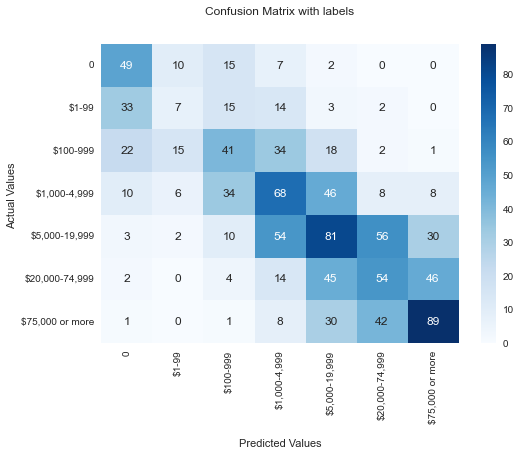

In [71]:
#confusion_matrix
conf_svc= confusion_matrix(target_test, y_pred_svc)

ax = sns.heatmap(conf_svc, annot=True, cmap='Blues',fmt='g')
ax.set_title('Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')
ax.set_xticklabels(['0','$1-99','$100-999','$1,000-4,999','$5,000-19,999','$20,000-74,999','$75,000 or more'])
ax.set_yticklabels(['0','$1-99','$100-999','$1,000-4,999','$5,000-19,999','$20,000-74,999','$75,000 or more'])
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

### LIME

LIME is a single instance explainer

In [86]:
# Get the class names
class_names = ['$0','$1-99','$100-999','$1,000-4,999','$5,000-19,999','$20,000-74,999','$75,000 or more']

# Get the feature names
feature_names = list(features_test_mice.columns)

# Fit the Explainer on the training data set using the LimeTabularExplainer 
lime_explainer_svc = LimeTabularExplainer(features_test_mice.values, feature_names = feature_names, 
                                 class_names = class_names, mode = 'classification')

### Single instance - index 2721 (824)

In [87]:
#Perform the explanation on the 8th instance in the test data
explaination_svc = lime_explainer_svc.explain_instance(features_test_mice.iloc[824], 
                                                       svc.best_estimator_[2].predict_proba, top_labels=1)

# show the result of the model's explaination
explaination_svc.show_in_notebook(show_table = True, show_all = False)

In [92]:
target_test[824]

6.0

Model prediction this observaiton is class 1 ($0), with confidence of 41%, while the actual class is 6.

In [73]:
#Save test, validation and test f1 weighted scores:
models_score['SVC'] = [round(svc.cv_results_['mean_train_score'].mean(),3),
                       round(svc.cv_results_['mean_test_score'].mean(),3),
                        round(f1_score(target_test, y_pred_svc, average='weighted'),3)]

# Logistic Regression

In [64]:
pipe = Pipeline([('over',RandomOverSampler(random_state=12345)), ('model',LogisticRegression())])

log_reg = best_model(pipe, {}, features_train_mice, target_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END ..............., score=(train=0.387, test=0.303) total time=   0.5s
[CV 2/5] END ..............., score=(train=0.382, test=0.319) total time=   0.5s
[CV 3/5] END ..............., score=(train=0.386, test=0.314) total time=   0.5s
[CV 4/5] END ..............., score=(train=0.385, test=0.348) total time=   0.6s
[CV 5/5] END ..............., score=(train=0.371, test=0.312) total time=   0.5s

Best parameters: {}

Best score: 0.32


In [65]:
y_pred_lr = log_reg.predict(features_test_mice)

In [66]:
print(classification_report(target_test, y_pred_lr, target_names=['0','$1-99','$100-999','$1,000-4,999',
                                                               '$5,000-19,999','$20,000-74,999','$75,000 or more']))

                 precision    recall  f1-score   support

              0       0.41      0.63      0.50        83
          $1-99       0.21      0.31      0.25        74
       $100-999       0.23      0.18      0.20       133
   $1,000-4,999       0.28      0.21      0.24       180
  $5,000-19,999       0.36      0.29      0.32       236
 $20,000-74,999       0.33      0.30      0.31       165
$75,000 or more       0.48      0.63      0.55       171

       accuracy                           0.35      1042
      macro avg       0.33      0.37      0.34      1042
   weighted avg       0.34      0.35      0.34      1042



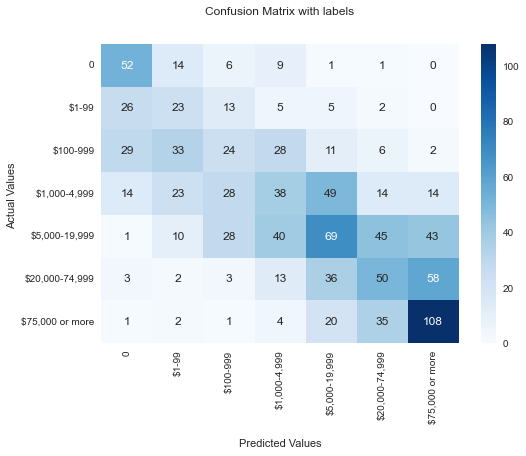

In [72]:
#confusion_matrix
conf_lr= confusion_matrix(target_test, y_pred_lr)

ax = sns.heatmap(conf_lr, annot=True, cmap='Blues',fmt='g')
ax.set_title('Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')
ax.set_xticklabels(['0','$1-99','$100-999','$1,000-4,999','$5,000-19,999','$20,000-74,999','$75,000 or more'])
ax.set_yticklabels(['0','$1-99','$100-999','$1,000-4,999','$5,000-19,999','$20,000-74,999','$75,000 or more'])
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

In [67]:
#Save test, validation and test f1 weighted scores:
models_score['Logisitc Regression'] = [round(log_reg.cv_results_['mean_train_score'].mean(),3),
                                       round(log_reg.cv_results_['mean_test_score'].mean(),3),
                                       round(f1_score(target_test, y_pred_lr, average='weighted'),3)]

# LightGBM

In [74]:
%%time
# n_estimators - number of boosting rounds that will be performed
# max_depth -  maximum distance between the root node of each tree and a leaf node
pipe = Pipeline([('over',RandomOverSampler(random_state=12345)), ('model',lgb.LGBMClassifier(random_state=12345))])

lgbm = best_model(pipe, {'model__learning_rate' : [0.01, 0.1],
                        'model__n_estimators' : [20, 80],
                        'model__max_depth' : [3, 5],
                        'model__num_leaves': [8, 15, 30],
                        'model__min_data_in_leaf': [10, 30]}, features_train_mice, target_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[CV 1/5] END model__learning_rate=0.01, model__max_depth=3, model__min_data_in_leaf=10, model__n_estimators=20, model__num_leaves=8;, score=(train=0.338, test=0.287) total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[CV 2/5] END model__learning_rate=0.01, model__max_depth=3, model__min_data_in_leaf=10, model__n_estimators=20, model__num_leaves=8;, score=(train=0.331, test=0.289) total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[CV 3/5] END model__learning_rate=0.01, model__max_depth=3, model__min_data_in_leaf=10, model__n_estimators=20, model__num_leaves=8;, score=(train=0.331, test=0.281) total time=   0.3s
[LightGBM] [Warni

In [75]:
y_pred_lgbm = lgbm.predict(features_test_mice)

print(classification_report(target_test, y_pred_lgbm, target_names=['0','$1-99','$100-999','$1,000-4,999',
                                                               '$5,000-19,999','$20,000-74,999','$75,000 or more']))

                 precision    recall  f1-score   support

              0       0.43      0.59      0.50        83
          $1-99       0.23      0.26      0.24        74
       $100-999       0.30      0.23      0.26       133
   $1,000-4,999       0.31      0.29      0.30       180
  $5,000-19,999       0.37      0.30      0.33       236
 $20,000-74,999       0.27      0.29      0.28       165
$75,000 or more       0.45      0.54      0.49       171

       accuracy                           0.35      1042
      macro avg       0.34      0.36      0.34      1042
   weighted avg       0.34      0.35      0.34      1042



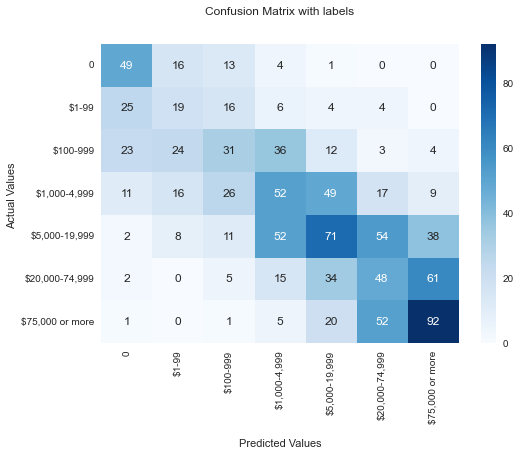

In [76]:
#confusion_matrix
conf_lgbm= confusion_matrix(target_test, y_pred_lgbm)

ax = sns.heatmap(conf_lgbm, annot=True, cmap='Blues',fmt='g')
ax.set_title('Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')
ax.set_xticklabels(['0','$1-99','$100-999','$1,000-4,999','$5,000-19,999','$20,000-74,999','$75,000 or more'])
ax.set_yticklabels(['0','$1-99','$100-999','$1,000-4,999','$5,000-19,999','$20,000-74,999','$75,000 or more'])
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

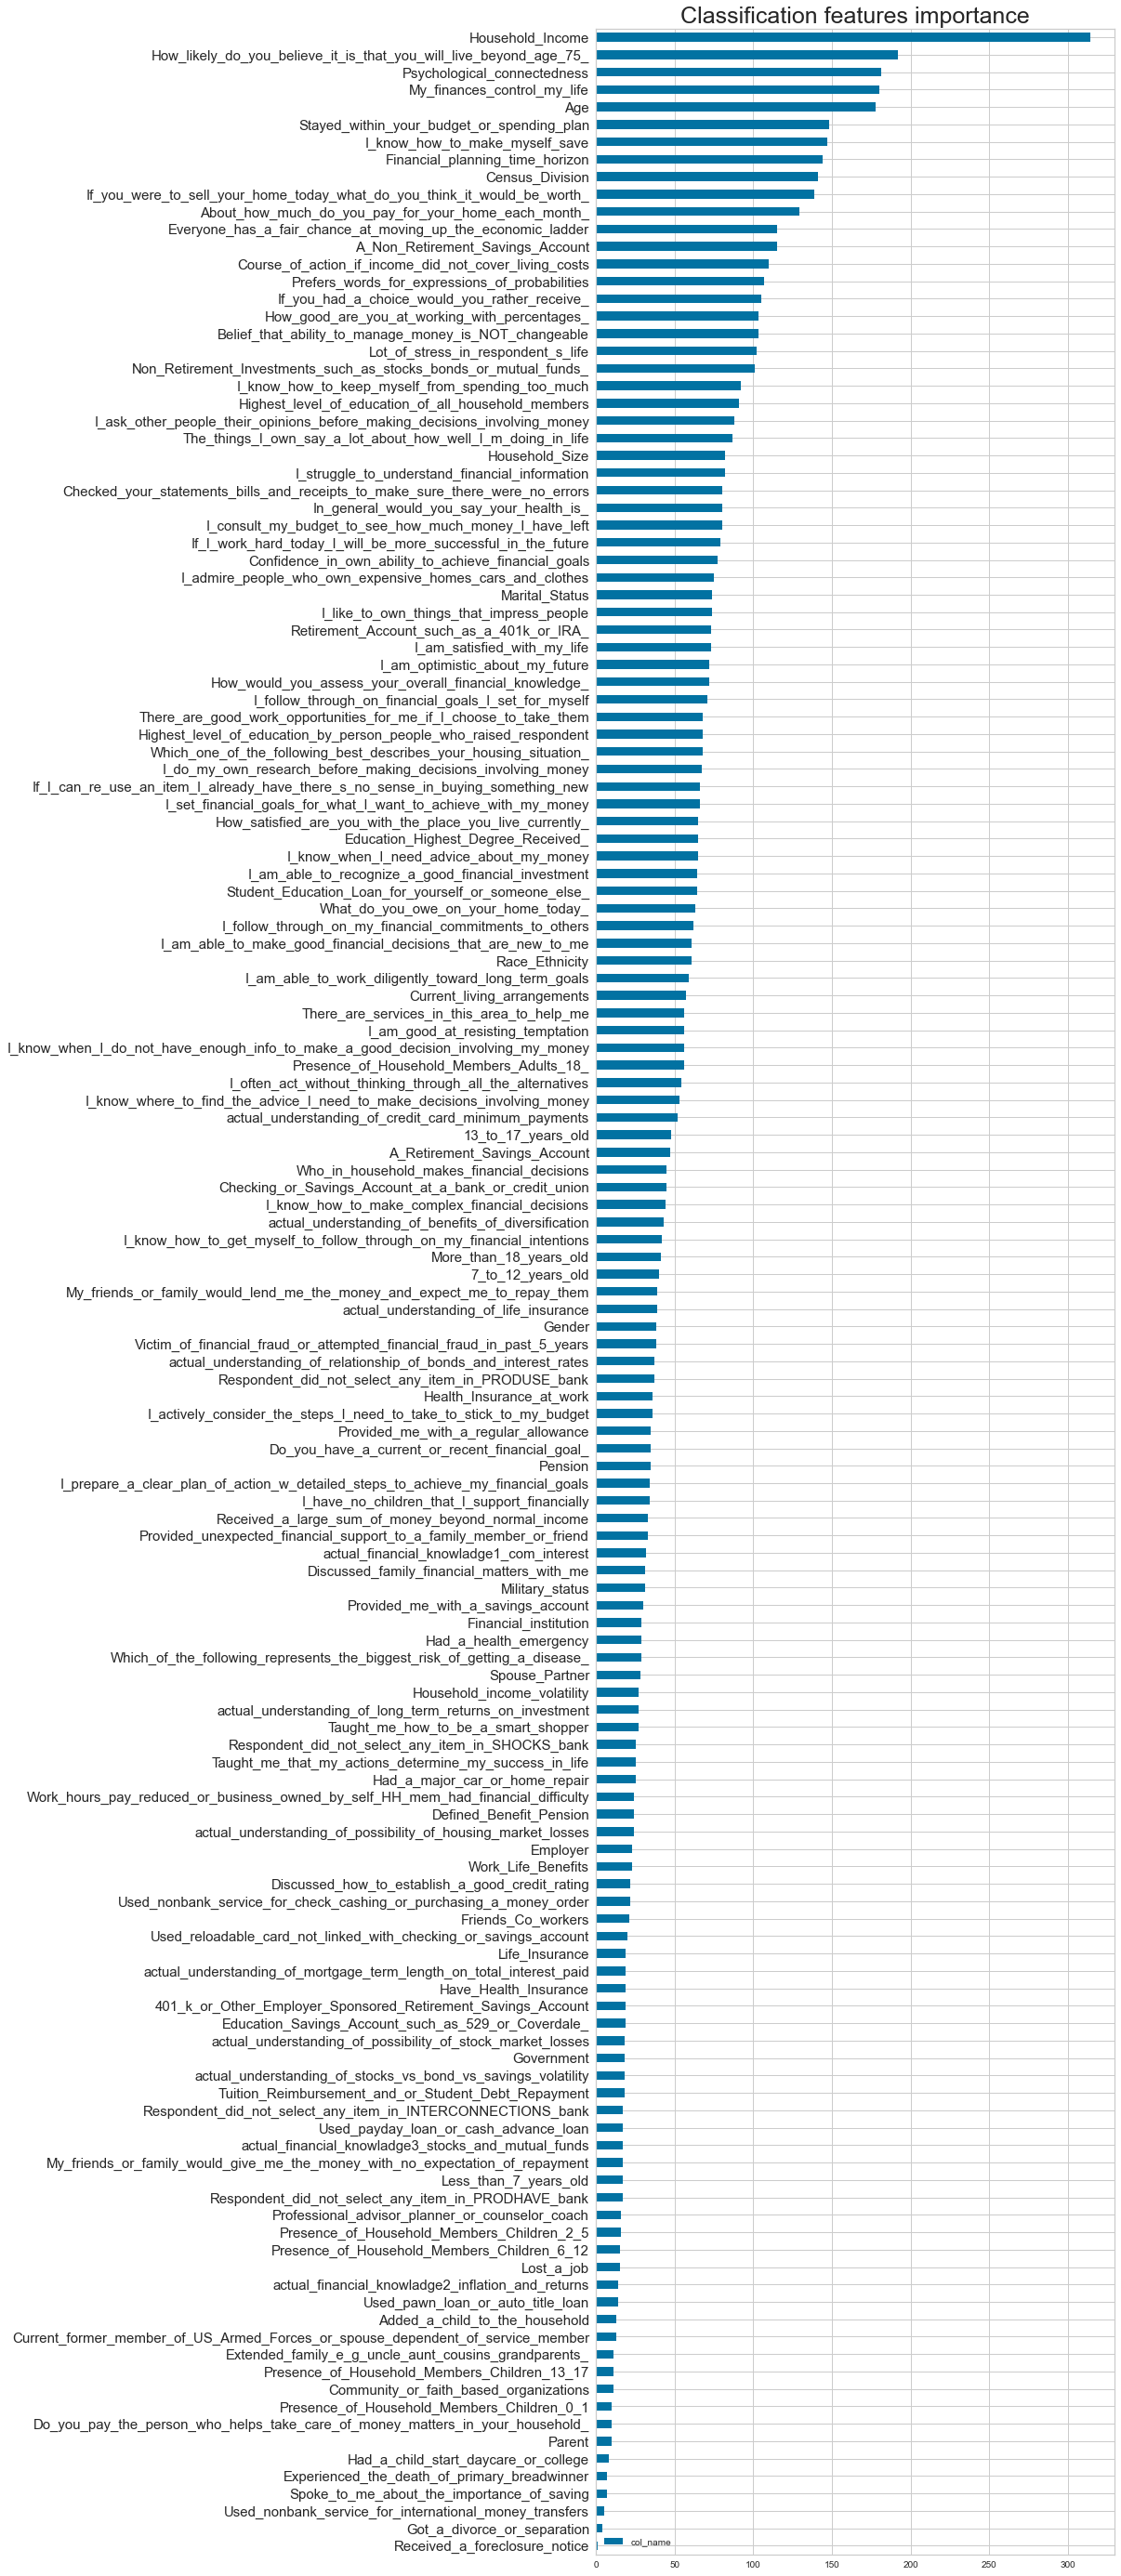

In [78]:
feature_importance_lgbm = pd.DataFrame({'col_name': lgbm.best_estimator_[1].feature_importances_}, index=features_train_mice.columns).sort_values(by='col_name', ascending=False)

fig, ax = plt.subplots(figsize =(10, 50))
feature_importance_lgbm.sort_values(by='col_name',ascending=True).plot(kind='barh', ax=ax)
plt.title('Classification features importance', size=25)
ax.tick_params(axis='y', labelsize=15)
plt.show()

In [77]:
#Save test, validation and test f1 weighted scores:
models_score['LightGBM'] = [round(lgbm.cv_results_['mean_train_score'].mean(),3),
                            round(lgbm.cv_results_['mean_test_score'].mean(),3),
                                       round(f1_score(target_test, y_pred_lgbm, average='weighted'),3)]

### SHAP - LightGBM

In [79]:
%%time
#See explanation for test set
explainer_lgbm_7 = shap.TreeExplainer(lgbm.best_estimator_[1])
shap_values_lgbm_7 = explainer_lgbm_7.shap_values(features_test_mice)

Wall time: 1.19 s


Class: $0


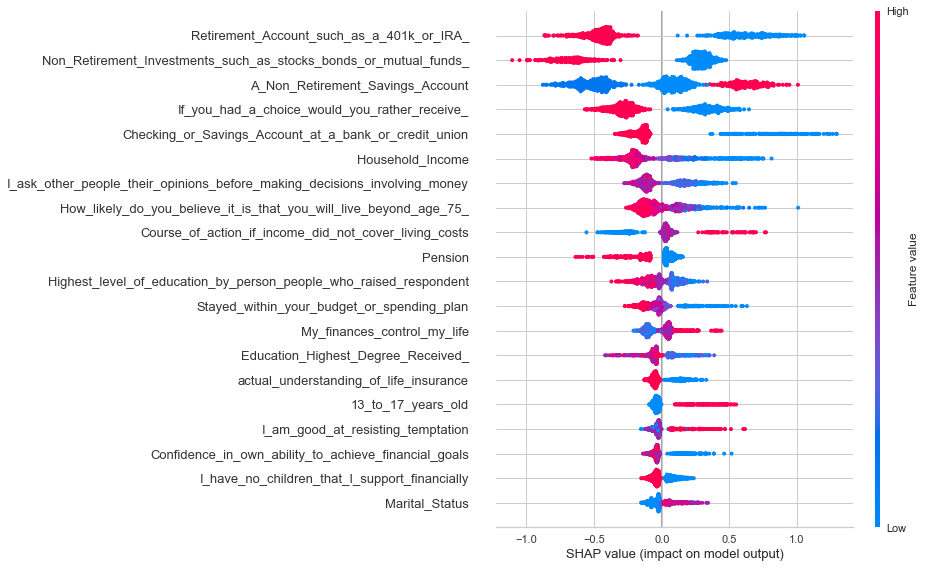

Class: $1-99


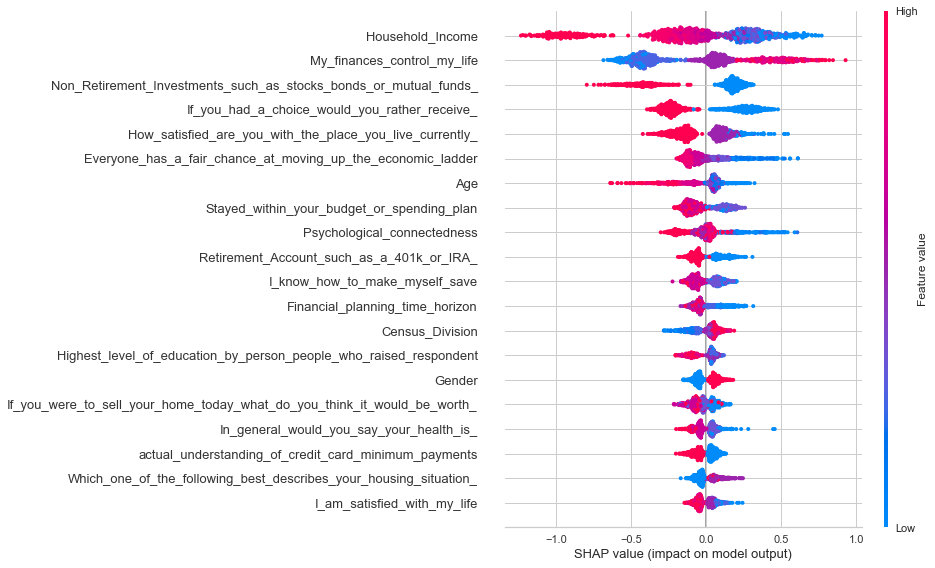

Class: $100-999


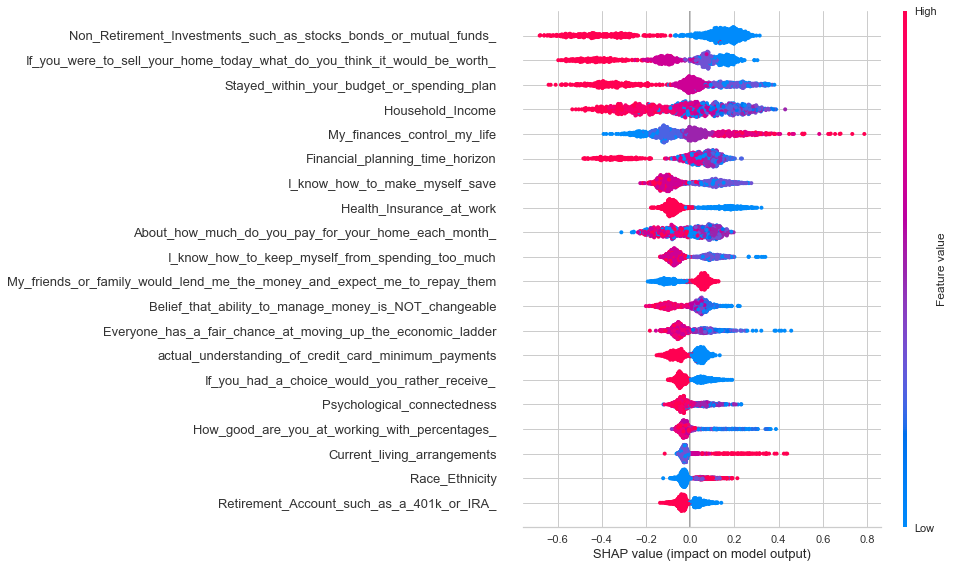

Class: $1,000-4,999


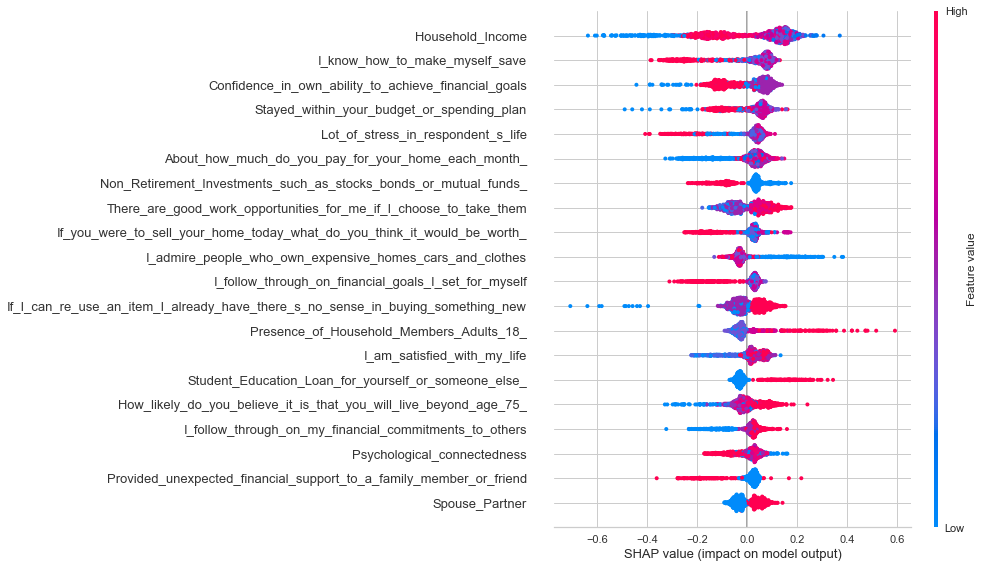

Class: $5,000-19,999


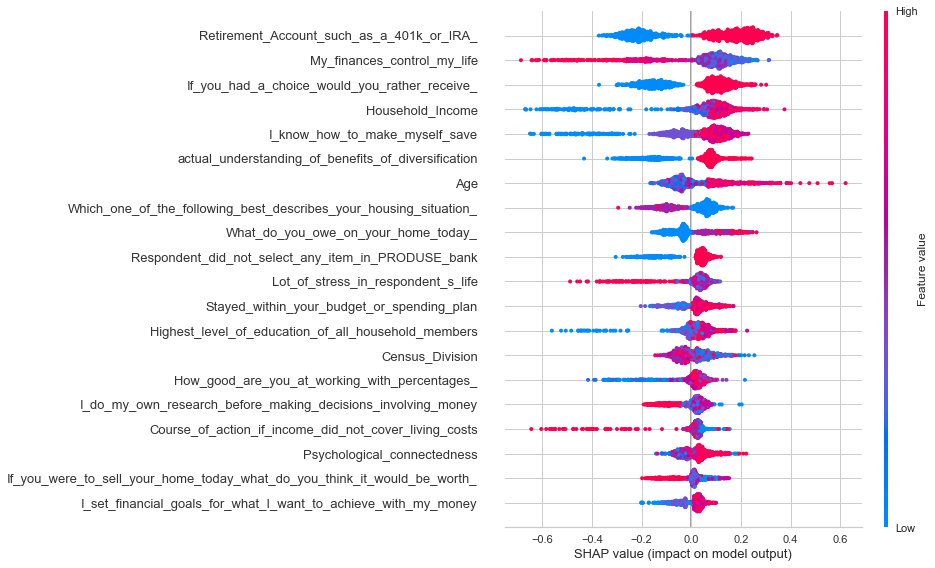

Class: $20,000-74,999


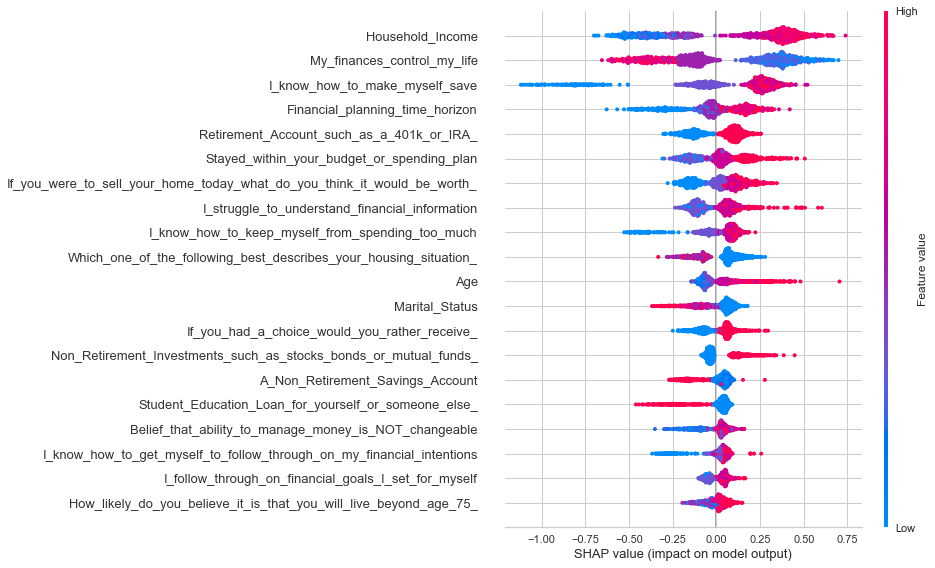

Class: $75,000 or more


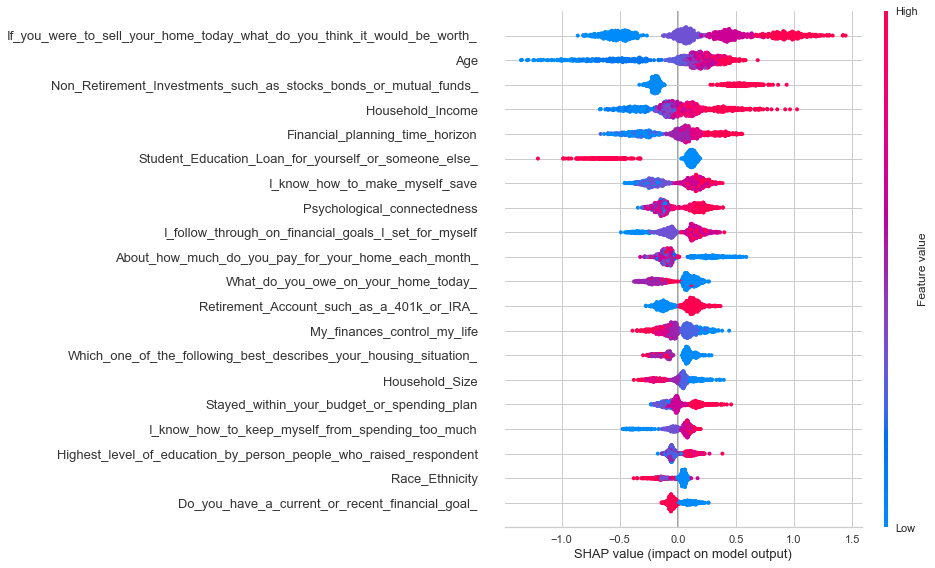

In [80]:
classes={1: '$0',
2: '$1-99', 
3: '$100-999',
4: '$1,000-4,999',
5: '$5,000-19,999',
6: '$20,000-74,999',
7: '$75,000 or more'}

for i in range(1,8):
    print('Class:', classes[i])
    shap.summary_plot(shap_values_lgbm_7[i-1], features_test_mice.values, feature_names = features_test_mice.columns)

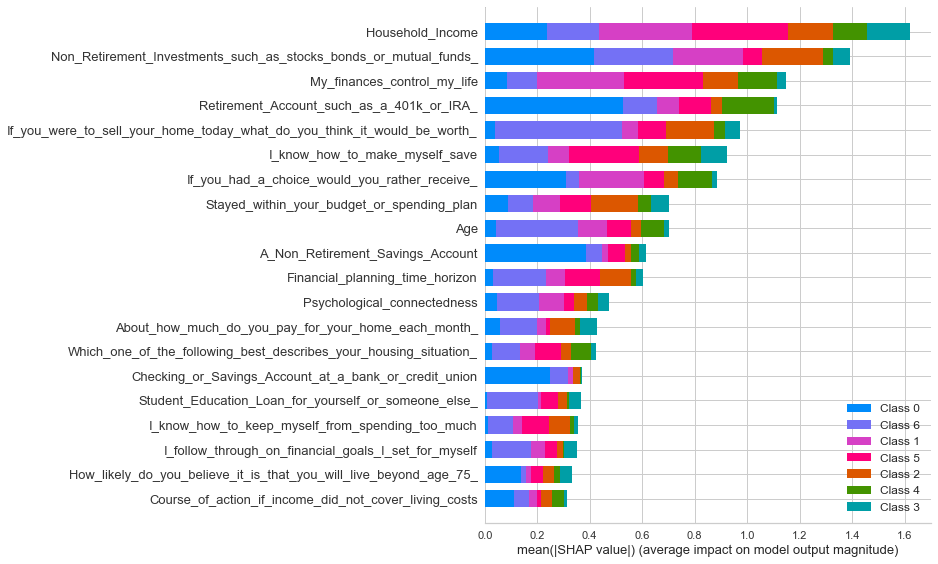

In [82]:
shap.summary_plot(shap_values_lgbm_7, features_test_mice.values, feature_names = features_test_mice.columns)

### ELI5

In [93]:
perm = PermutationImportance(lgbm.best_estimator_[1], scoring = 'f1_weighted' ,random_state=42).fit(features_test_mice, target_test)

In [94]:
show_weights(perm, feature_names = list(features_test_mice.columns))

### Look at misclassification

In [95]:
show_prediction(lgbm.best_estimator_[1], features_test_mice.iloc[842], show_feature_values=True)

## Results

In [83]:
pd.DataFrame.from_dict(models_score, orient='index', columns=['Train F1 weighted',
                                                              'Valid F1 weighted','Test F1 weighted']).sort_values(by='Test F1 weighted', ascending=False)

Train F1 weighted  Valid F1 weighted  Test F1 weighted
SVC                              0.489              0.226             0.367
LightGBM                         0.521              0.317             0.342
Logisitc Regression              0.382              0.319             0.338

## Conclusions - 7 Classes

Althoug the F1 score is low, about 37%, we see that it is still good, because we have 7 categories, and the probability for random classification is 15%.

Looking at the confusion matrix we see many clasiffication mistakes, but some of the mistakes might be accetapble, such as the differnce between people with USD 0 to USD 1-99, or USD 100 - 999 to USD 1,000 to 4,999 maybe not that far.

Also, for example there might be people with USD 65,000 and people with USD 75,000, and appear under differnt classes.

Maybe so many clases are too much for classification task, where the label represent too close classes. Maybe we need to divide the labels to sub categories.

We might try start with prediction of USD 0 to USD 4,999 for lower level of saving and USD 5,000 to 19,999 to mid-level and USD 20,000 and above to higher levels of saving.

# -----------------------------------------------------------------------------------------------------------

# <u>Predict 3 classes - Low, Mid, High</u> <a class="anchor" id="part_IV_3"></a>

[Table of content](#toc)

In [84]:
#Create empty tuple for score
models_score_3 = {}

1. USD 0 - Low
2. USD 1-99 - Low
3. USD 100-999 - Low
4. USD 1,000-4,999 - Mid
5. USD 5,000-19,999 - Mid
6. USD 20,000-74,999 - High
7. USD 75,000 or more - High

In [85]:
#Convert 7 classes into 3 classes - train set
target_train_3 = [1 if x==1 else 1 if x==2 else 1 if x==3 else 2 if x==4 else 2 if x==5 else 3 if x==6 else 3 for x in target_train]
target_train_3 = pd.Series(target_train_3, index=target_train.index)

#Convert 7 classes into 3 classes - test set
target_test_3 = [1 if x==1 else 1 if x==2 else 1 if x==3 else 2 if x==4 else 2 if x==5 else 3 if x==6 else 3 for x in target_test]
target_test_3 = pd.Series(target_test_3, index=target_test.index)

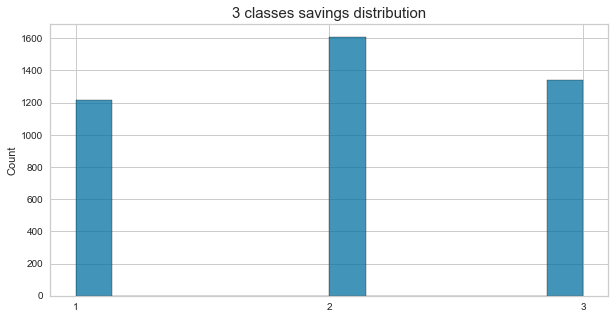

In [96]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(target_train_3, ax=ax)
plt.title('3 classes savings distribution', size=15)
plt.xticks(np.arange(min(target_train_3), max(target_train_3)+1, 1.0))
plt.show()

The target seems more balance than not.

## SVC

In [117]:
%%time

# C - Regularization parameter. The strength of the regularization is inversely proportional to C. 
# Must be strictly positive. The penalty is a squared l2 penalty.

# gamma - The gamma parameters can be seen as the inverse of the radius of influence of 
# samples selected by the model as support vectors. When gamma is very small, the model is too constrained and cannot capture 
# the complexity or “shape” of the data.  
#Gamma essentially controls the distance of influence of a single training point.
#-Low values of Gamma indicate a large similarity radius which results in more points being grouped together.
#-For High values of Gamma, the points need to be very close to each other in order for it to be considered in the same group.


pipe = Pipeline([('scaler',StandardScaler()),('model',SVC())])

param_grid = {'model__C': [1, 1.5],
              'model__gamma':[0.005, 0.01,'scale','auto'],
              'model__kernel': ['rbf'], 'model__probability':[True]}

svc_3 = best_model(pipe, param_grid, features_train_mice, target_train_3)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END model__C=1, model__gamma=0.005, model__kernel=rbf, model__probability=True;, score=(train=0.828, test=0.664) total time=   5.9s
[CV 2/5] END model__C=1, model__gamma=0.005, model__kernel=rbf, model__probability=True;, score=(train=0.831, test=0.660) total time=   5.0s
[CV 3/5] END model__C=1, model__gamma=0.005, model__kernel=rbf, model__probability=True;, score=(train=0.821, test=0.667) total time=   6.9s
[CV 4/5] END model__C=1, model__gamma=0.005, model__kernel=rbf, model__probability=True;, score=(train=0.832, test=0.665) total time=   7.6s
[CV 5/5] END model__C=1, model__gamma=0.005, model__kernel=rbf, model__probability=True;, score=(train=0.823, test=0.685) total time=   6.9s
[CV 1/5] END model__C=1, model__gamma=0.01, model__kernel=rbf, model__probability=True;, score=(train=0.926, test=0.659) total time=   9.6s
[CV 2/5] END model__C=1, model__gamma=0.01, model__kernel=rbf, model__probability=True;, score=

In [118]:
y_pred_svc_3 = svc_3.predict(features_test_mice)


print(classification_report(target_test_3, y_pred_svc_3, target_names=['Low',
                                                               'Mid','High']))

              precision    recall  f1-score   support

         Low       0.78      0.72      0.75       290
         Mid       0.62      0.63      0.63       416
        High       0.69      0.73      0.71       336

    accuracy                           0.69      1042
   macro avg       0.70      0.69      0.70      1042
weighted avg       0.69      0.69      0.69      1042



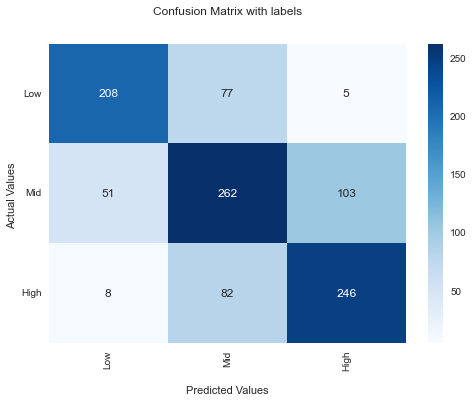

In [123]:
#confusion_matrix
conf_svc_3= confusion_matrix(target_test_3, y_pred_svc_3)

ax = sns.heatmap(conf_svc_3, annot=True, cmap='Blues',fmt='g')
ax.set_title('Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')
ax.set_xticklabels(['Low','Mid','High'])
ax.set_yticklabels(['Low','Mid','High'])
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

In [119]:
#Save f1 weighted scores:
models_score_3['SVC'] = [round(svc_3.cv_results_['mean_train_score'].mean(),2),
                            round(svc_3.cv_results_['mean_test_score'].mean(),2),
                                       round(f1_score(target_test_3, y_pred_svc_3, average='weighted'),2)]

## Random Forest

In [120]:
%%time
# n_estimators - This is the number of trees
# max_depth - The maximum depth of the tree. Need to restriced to avoid overfitting
pipe = Pipeline([('model',RandomForestClassifier(random_state=12345))])

rf_3 = best_model(pipe, {'model__n_estimators' : [100, 200],
                        'model__max_depth' : [5,8],
                      'model__min_samples_split':[10, 20],
                      'model__min_samples_leaf':[10,20]}, features_train_mice, target_train_3)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5] END model__max_depth=5, model__min_samples_leaf=10, model__min_samples_split=10, model__n_estimators=100;, score=(train=0.691, test=0.634) total time=   0.4s
[CV 2/5] END model__max_depth=5, model__min_samples_leaf=10, model__min_samples_split=10, model__n_estimators=100;, score=(train=0.696, test=0.635) total time=   0.4s
[CV 3/5] END model__max_depth=5, model__min_samples_leaf=10, model__min_samples_split=10, model__n_estimators=100;, score=(train=0.690, test=0.642) total time=   0.4s
[CV 4/5] END model__max_depth=5, model__min_samples_leaf=10, model__min_samples_split=10, model__n_estimators=100;, score=(train=0.692, test=0.644) total time=   0.5s
[CV 5/5] END model__max_depth=5, model__min_samples_leaf=10, model__min_samples_split=10, model__n_estimators=100;, score=(train=0.694, test=0.664) total time=   0.5s
[CV 1/5] END model__max_depth=5, model__min_samples_leaf=10, model__min_samples_split=10, model__n_estim

In [121]:
y_pred_rf_3 = rf_3.predict(features_test_mice)


print(classification_report(target_test_3, y_pred_rf_3, target_names=['Low',
                                                               'Mid','High']))

              precision    recall  f1-score   support

         Low       0.78      0.73      0.76       290
         Mid       0.61      0.64      0.62       416
        High       0.69      0.69      0.69       336

    accuracy                           0.68      1042
   macro avg       0.69      0.69      0.69      1042
weighted avg       0.68      0.68      0.68      1042



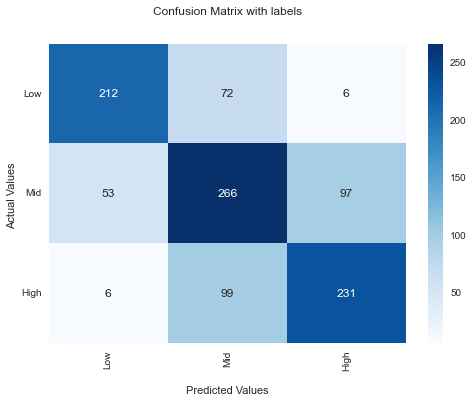

In [122]:
#confusion_matrix
conf_rf_3= confusion_matrix(target_test_3, y_pred_rf_3)

ax = sns.heatmap(conf_rf_3, annot=True, cmap='Blues',fmt='g')
ax.set_title('Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')
ax.set_xticklabels(['Low','Mid','High'])
ax.set_yticklabels(['Low','Mid','High'])
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

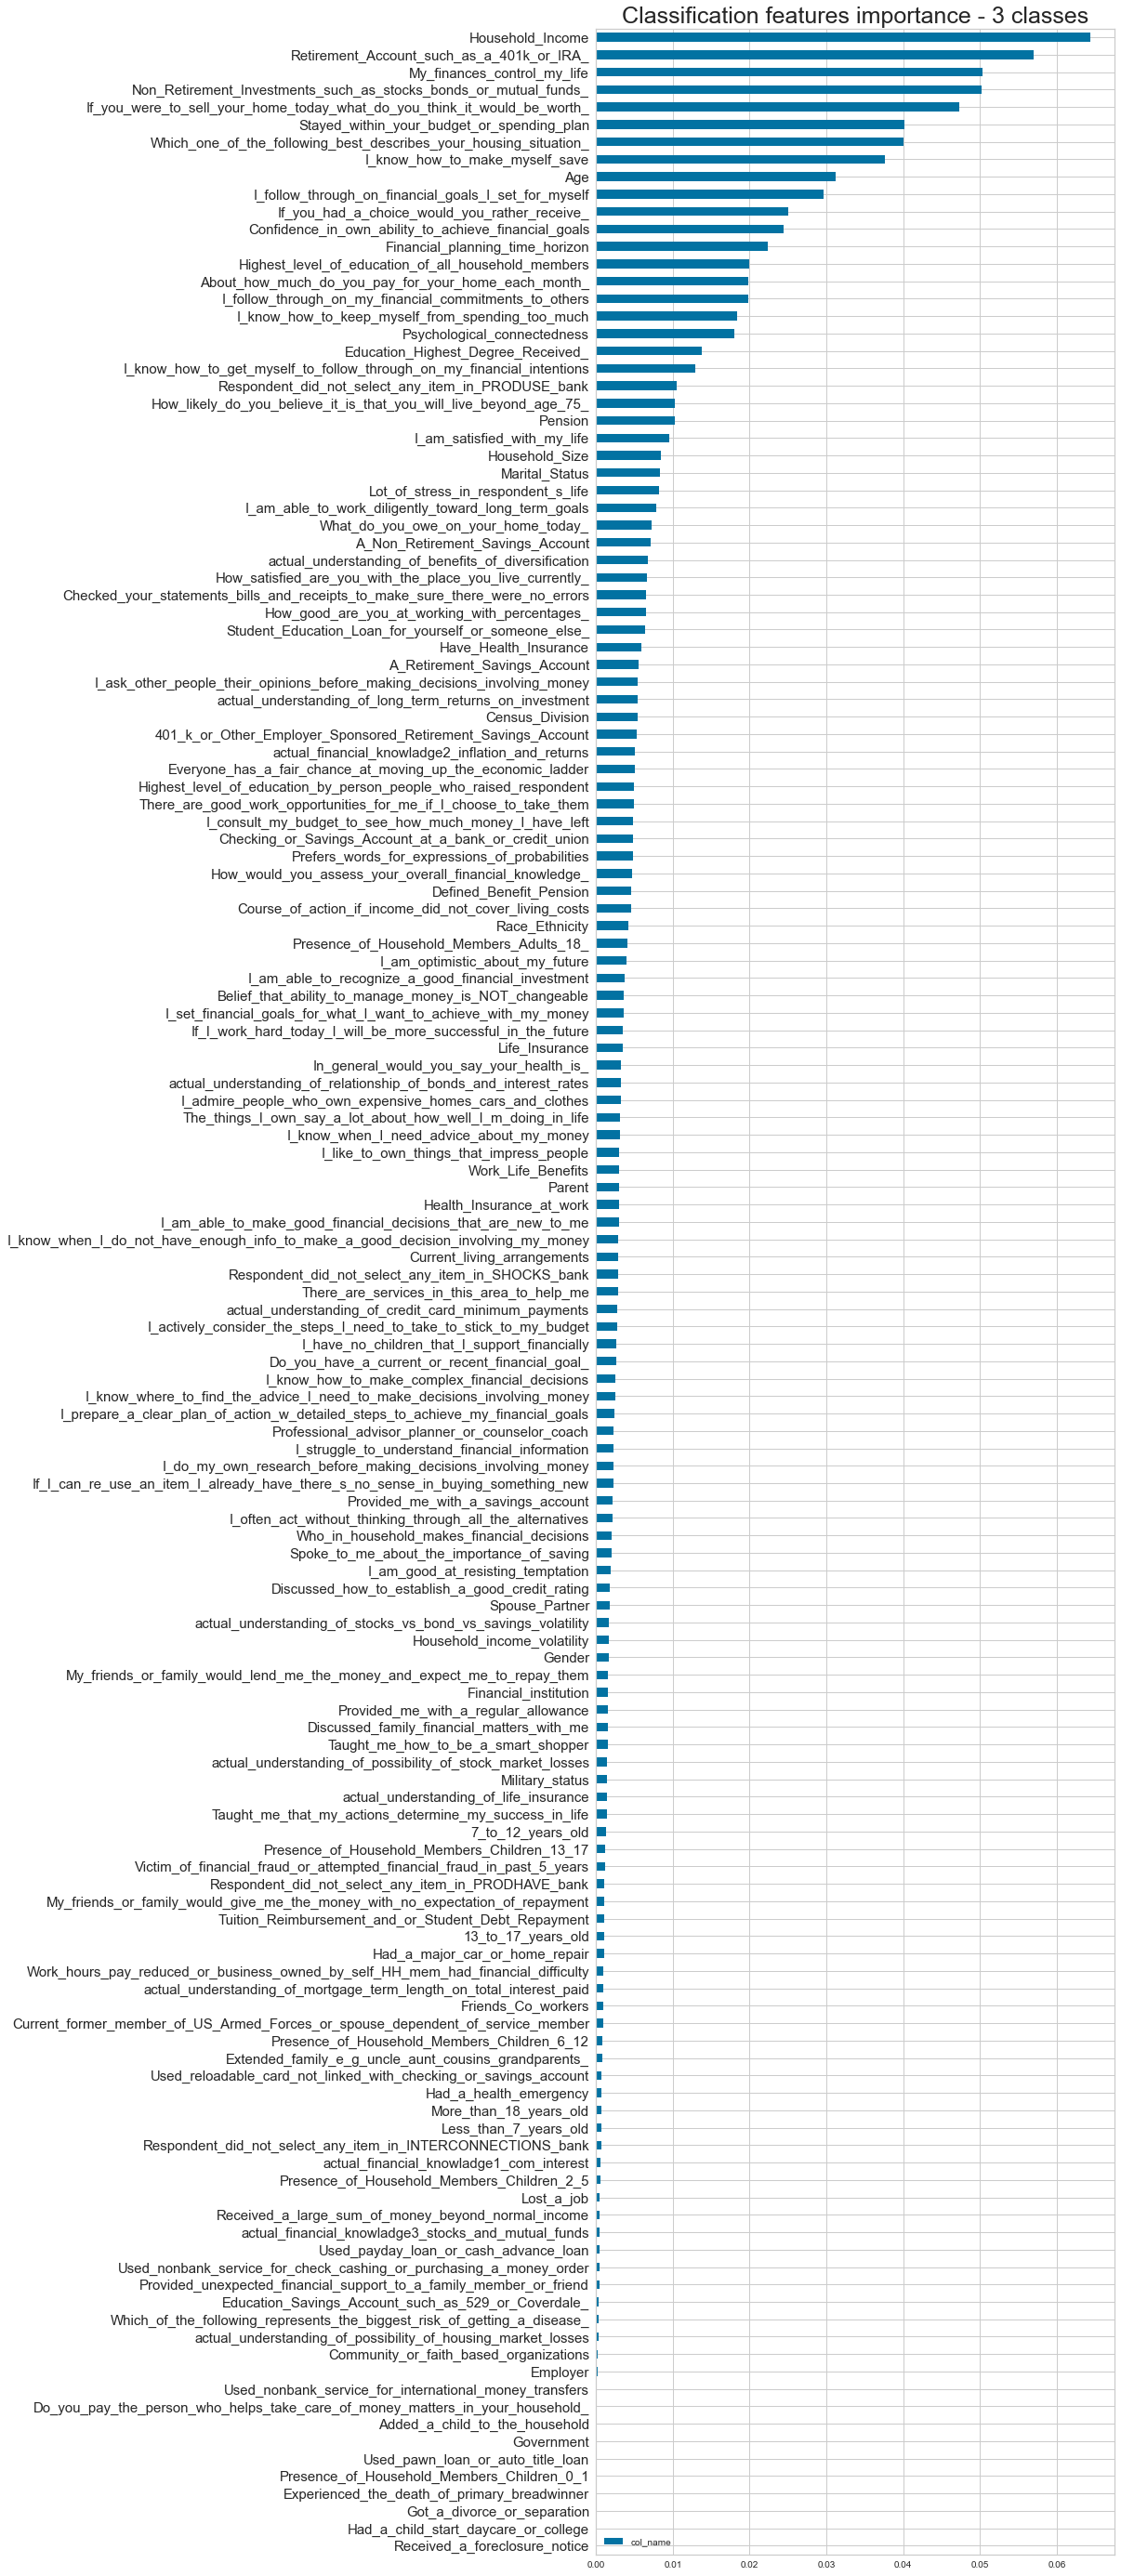

In [125]:
feature_importance_3_classes = pd.DataFrame({'col_name': rf_3.best_estimator_[0].feature_importances_}, index=features_train_mice.columns).sort_values(by='col_name', ascending=False)

fig, ax = plt.subplots(figsize =(10, 50))
feature_importance_3_classes.sort_values(by='col_name',ascending=True).plot(kind='barh', ax=ax)
plt.title('Classification features importance - 3 classes', size=25)
ax.tick_params(axis='y', labelsize=15)
plt.show()

In [126]:
%%time
#See explanation for test set
explainer_3 = shap.TreeExplainer(rf_3.best_estimator_[0])
shap_values_3 = explainer_3.shap_values(features_test_mice)

Wall time: 12.1 s


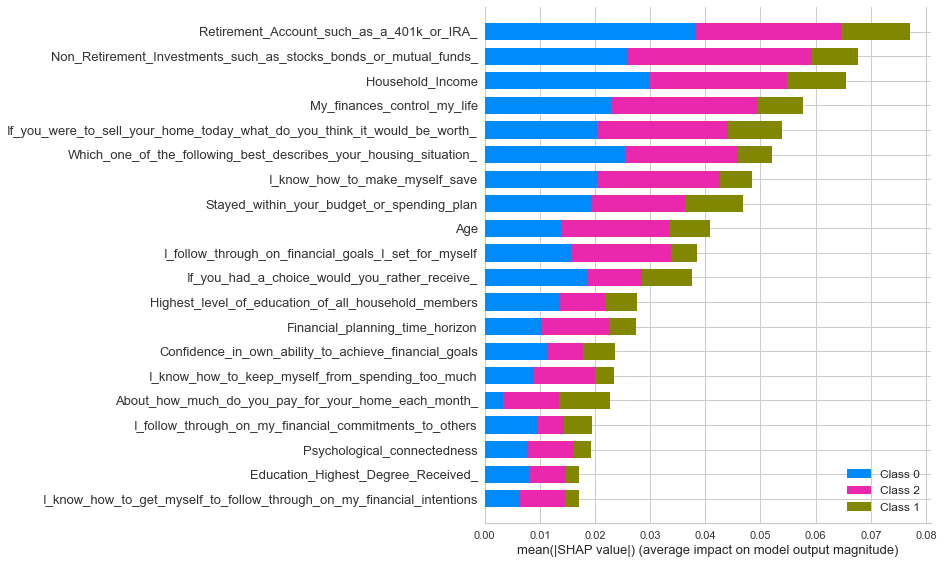

In [127]:
shap.summary_plot(shap_values_3, features_test_mice.values, feature_names = features_test_mice.columns)

Class: Low


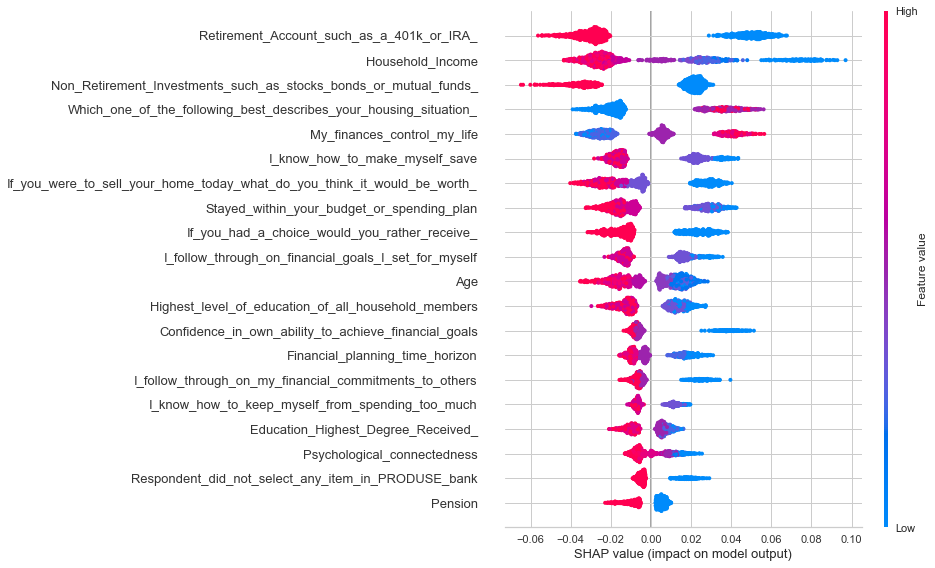

Class: Mid


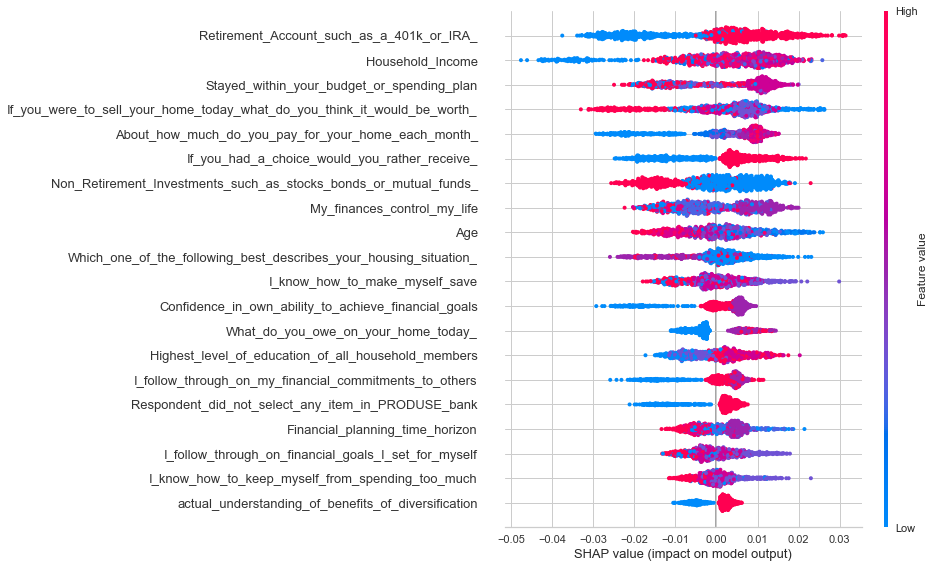

Class: High


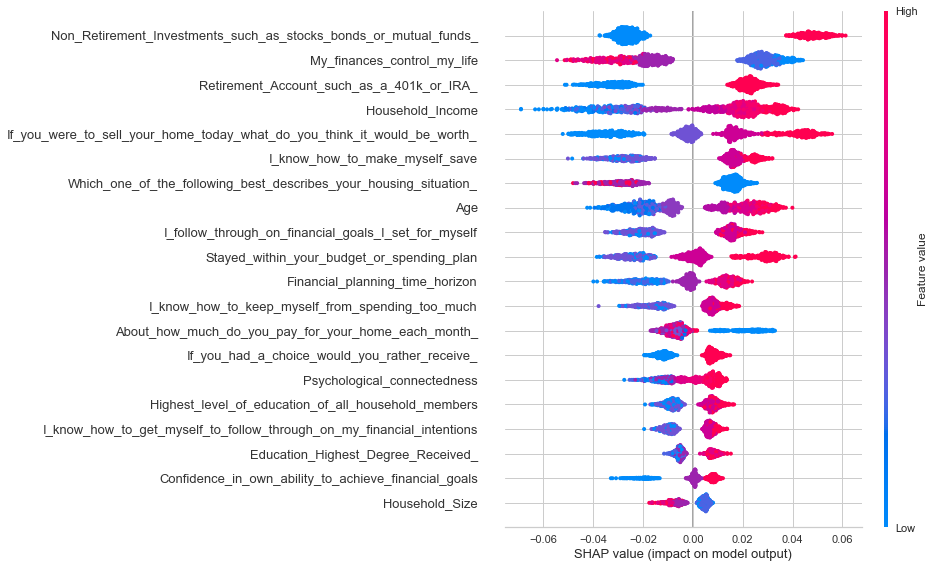

In [128]:
classes_3={1: 'Low',
2: 'Mid', 
3: 'High'}

for i in range(1,4):
    print('Class:', classes_3[i])
    shap.summary_plot(shap_values_3[i-1], features_test_mice.values, feature_names = features_test_mice.columns)

In [129]:
#Save f1 weighted scores:
models_score_3['Random_forest'] = [round(rf_3.cv_results_['mean_train_score'].mean(),2),
                            round(rf_3.cv_results_['mean_test_score'].mean(),2),
                                       round(f1_score(target_test_3, y_pred_rf_3, average='weighted'),2)]

## LightGBM

In [130]:
%%time
# n_estimators - number of boosting rounds that will be performed
# max_depth -  maximum distance between the root node of each tree and a leaf node
pipe = Pipeline([('over',RandomOverSampler(random_state=12345)), ('model',lgb.LGBMClassifier(random_state=12345))])

lgbm_3 = best_model(pipe, {'model__learning_rate' : [0.01, 0.1],
                        'model__n_estimators' : [20, 80],
                        'model__max_depth' : [3, 5],
                        'model__num_leaves': [8, 15, 30],
                        'model__min_data_in_leaf': [10, 30]}, features_train_mice, target_train_3)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[CV 1/5] END model__learning_rate=0.01, model__max_depth=3, model__min_data_in_leaf=10, model__n_estimators=20, model__num_leaves=8;, score=(train=0.583, test=0.552) total time=   0.2s
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[CV 2/5] END model__learning_rate=0.01, model__max_depth=3, model__min_data_in_leaf=10, model__n_estimators=20, model__num_leaves=8;, score=(train=0.594, test=0.570) total time=   0.1s
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[CV 3/5] END model__learning_rate=0.01, model__max_depth=3, model__min_data_in_leaf=10, model__n_estimators=20, model__num_leaves=8;, score=(train=0.577, test=0.553) total time=   0.1s
[LightGBM] [Warni

In [131]:
y_pred_lgbm_3 = lgbm_3.predict(features_test_mice)

print(classification_report(target_test_3, y_pred_lgbm_3, target_names=['Low','Mid','High']))

              precision    recall  f1-score   support

         Low       0.74      0.76      0.75       290
         Mid       0.63      0.54      0.58       416
        High       0.66      0.77      0.71       336

    accuracy                           0.67      1042
   macro avg       0.68      0.69      0.68      1042
weighted avg       0.67      0.67      0.67      1042



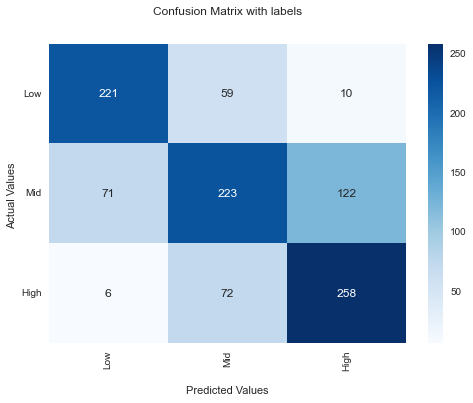

In [132]:
#confusion_matrix
conf_lgbm_3= confusion_matrix(target_test_3, y_pred_lgbm_3)

ax = sns.heatmap(conf_lgbm_3, annot=True, cmap='Blues',fmt='g')
ax.set_title('Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')
ax.set_xticklabels(['Low','Mid','High'])
ax.set_yticklabels(['Low','Mid','High'])
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

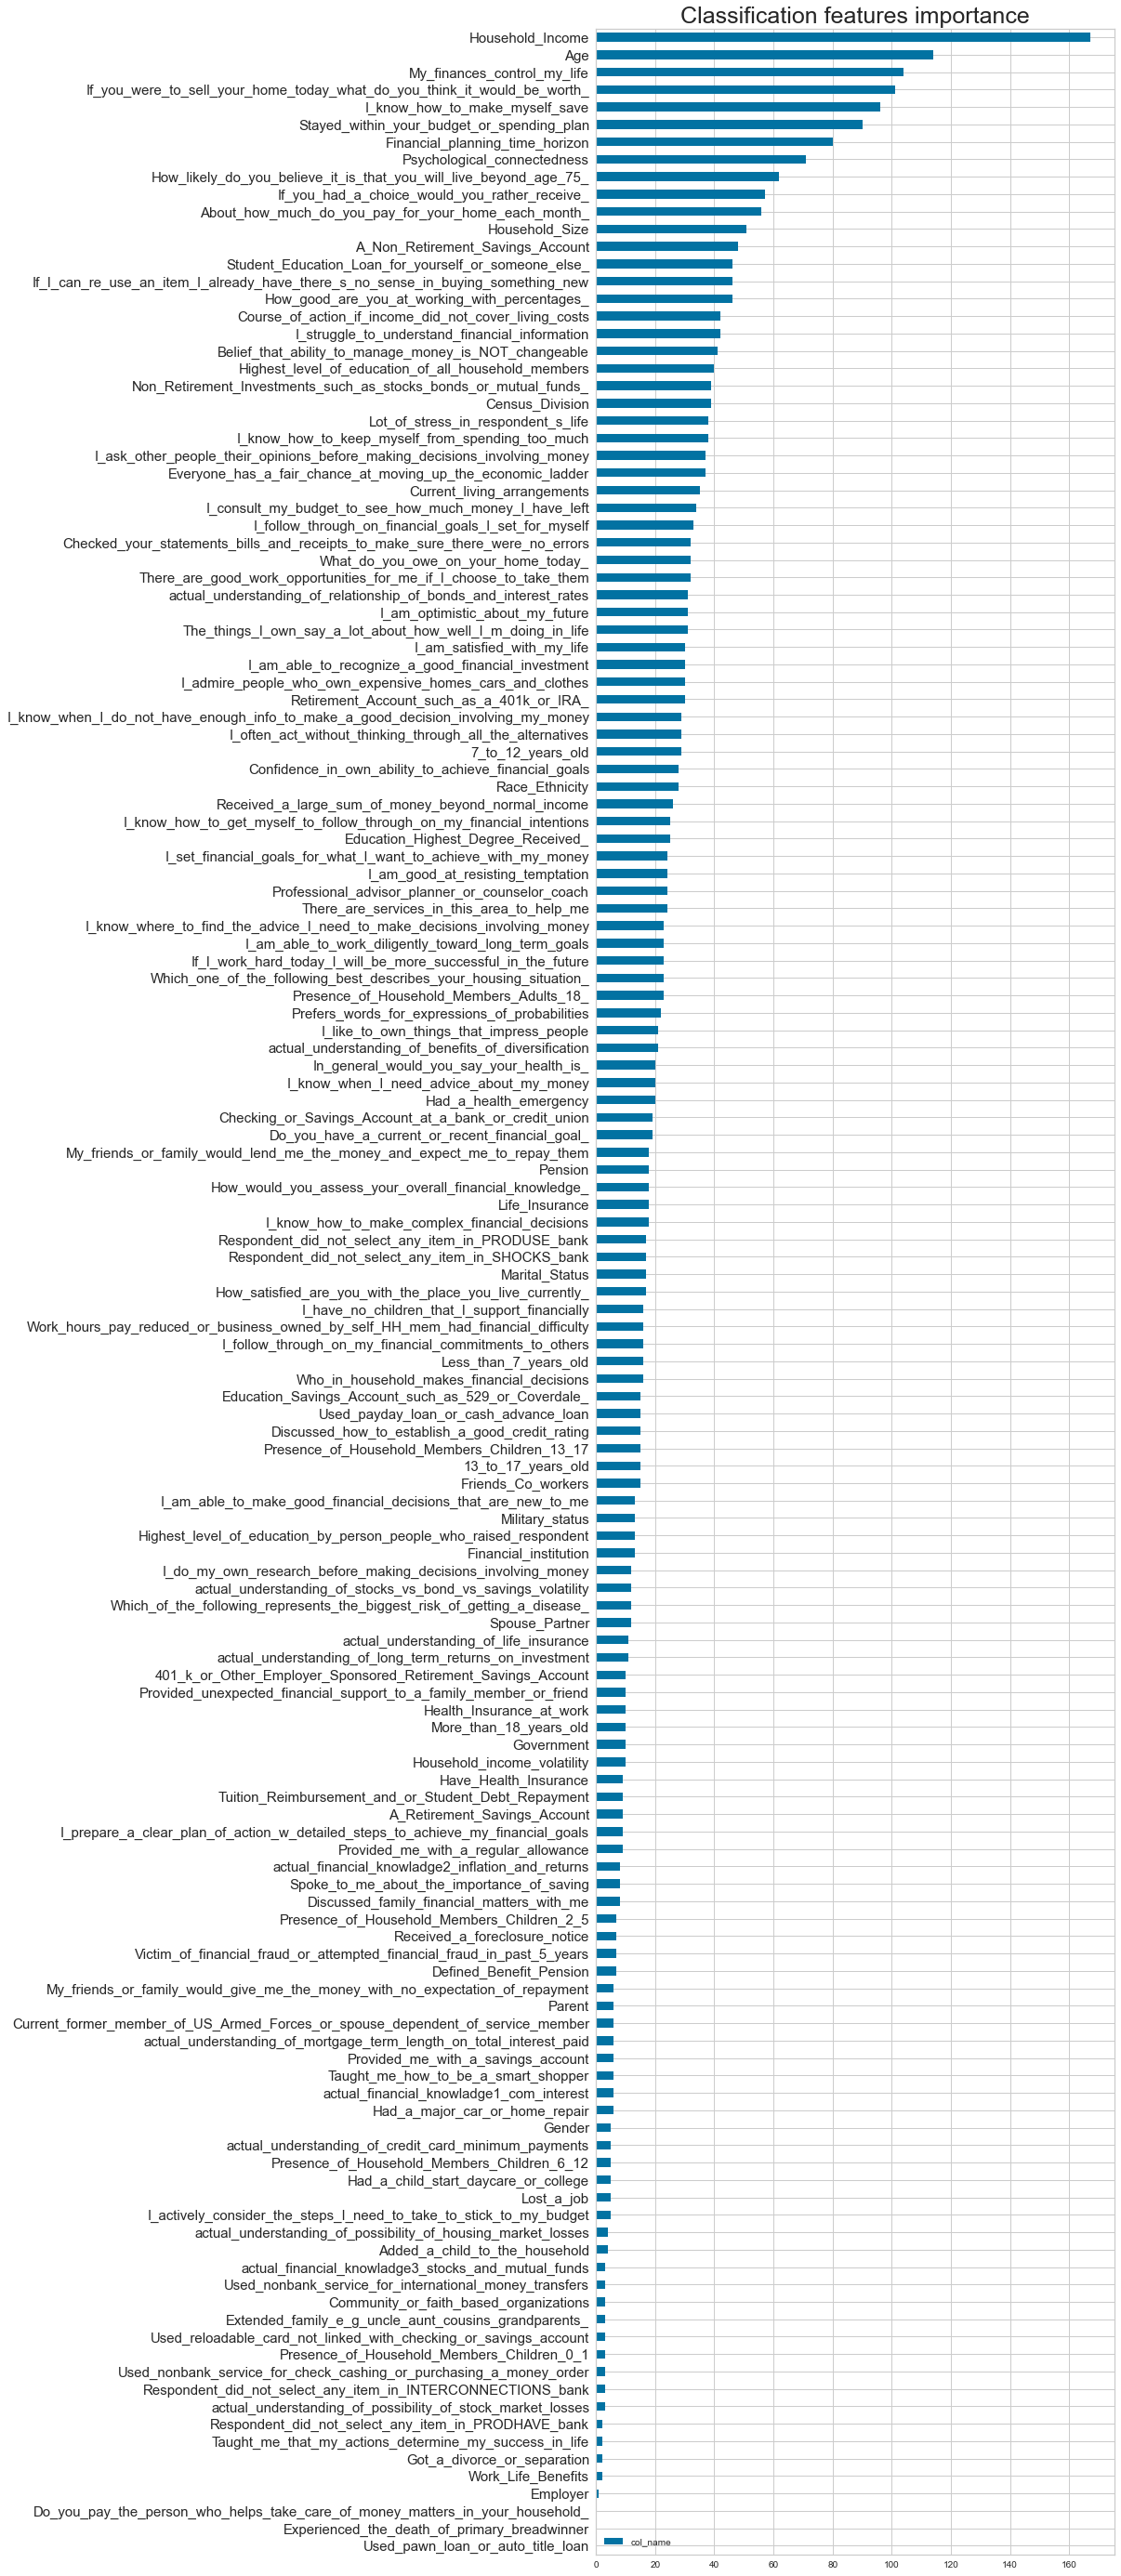

In [133]:
feature_importance_lgbm_3 = pd.DataFrame({'col_name': lgbm_3.best_estimator_[1].feature_importances_}, index=features_train_mice.columns).sort_values(by='col_name', ascending=False)

fig, ax = plt.subplots(figsize =(10, 50))
feature_importance_lgbm_3.sort_values(by='col_name',ascending=True).plot(kind='barh', ax=ax)
plt.title('Classification features importance', size=25)
ax.tick_params(axis='y', labelsize=15)
plt.show()

In [134]:
#Save f1 weighted scores:
models_score_3['LightGBM'] = [round(lgbm_3.cv_results_['mean_train_score'].mean(),2),
                            round(lgbm_3.cv_results_['mean_test_score'].mean(),2),
                                       round(f1_score(target_test_3, y_pred_lgbm_3, average='weighted'),2)]

## Results

In [135]:
pd.DataFrame.from_dict(models_score_3, orient='index', columns=['Train F1 weighted',
                                                              'Valid F1 weighted','Test F1 weighted']).sort_values(by='Test F1 weighted', ascending=False)

Train F1 weighted  Valid F1 weighted  Test F1 weighted
SVC                         0.90               0.66              0.69
Random_forest               0.72               0.65              0.68
LightGBM                    0.69               0.61              0.67

# Conclusion - 3 classes

We see that in the 3 classes model, random probability to get into one of the 3 groups is 33%, while the accuracy and the F1 score are about 69% which is pretty impressive to know that we can predict saving situation based on number of financial questions.

# -----------------------------------------------------------------------------------------------------------

# <u>Regression 7 and 3 classes</u>  <a class="anchor" id="part_IV_reg"></a>

[Table of content](#toc)

## SVR - 3 classes

In [97]:
%%time

#Parameters for GridSearchCV

#C - penalty for each error. Low C is low error and the model more generelized. 0.1 < c < 100

#gamma - used only with rbf and means curvature. Low gamma, more generaliztion. Large gamma,  
#points need to be very close to each other, creates overfitting. 0.0001 < gamma < 10

pipe = Pipeline([('over',RandomOverSampler(random_state=12345)), ('scaler',StandardScaler()),('model',SVR())])

param_grid = {'model__C': [0.05, 0.1,1],
              'model__gamma': [1, 0.1, 0.01, 0.001],
              'model__kernel': ['rbf']}

svr_3 = best_model_regression(pipe, param_grid, features_train_mice, target_train_3)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END model__C=0.05, model__gamma=1, model__kernel=rbf;, score=(train=-0.578, test=-0.606) total time=   4.0s
[CV 2/5] END model__C=0.05, model__gamma=1, model__kernel=rbf;, score=(train=-0.574, test=-0.620) total time=   3.2s
[CV 3/5] END model__C=0.05, model__gamma=1, model__kernel=rbf;, score=(train=-0.572, test=-0.626) total time=   2.5s
[CV 4/5] END model__C=0.05, model__gamma=1, model__kernel=rbf;, score=(train=-0.574, test=-0.621) total time=   2.5s
[CV 5/5] END model__C=0.05, model__gamma=1, model__kernel=rbf;, score=(train=-0.580, test=-0.599) total time=   2.2s
[CV 1/5] END model__C=0.05, model__gamma=0.1, model__kernel=rbf;, score=(train=-0.578, test=-0.606) total time=   2.2s
[CV 2/5] END model__C=0.05, model__gamma=0.1, model__kernel=rbf;, score=(train=-0.574, test=-0.620) total time=   2.5s
[CV 3/5] END model__C=0.05, model__gamma=0.1, model__kernel=rbf;, score=(train=-0.573, test=-0.626) total time=   2.

In [98]:
y_pred_svr_3 = svr_3.predict(features_test_mice)

#Create a copy
y_pred_svr_3_round = np.round(y_pred_svr_3)

#Make 0 prediction to 1
for i in range(0,len(y_pred_svr_3_round)):
    if y_pred_svr_3_round[i]==0:
        y_pred_svr_3_round[i] = 1
    elif y_pred_svr_3_round[i]==4:
        y_pred_svr_3_round[i] = 3
        
print(classification_report(target_test_3, y_pred_svr_3_round, target_names=['Low','Mid','High']))

              precision    recall  f1-score   support

         Low       0.78      0.65      0.71       290
         Mid       0.59      0.68      0.63       416
        High       0.72      0.68      0.70       336

    accuracy                           0.67      1042
   macro avg       0.70      0.67      0.68      1042
weighted avg       0.68      0.67      0.67      1042



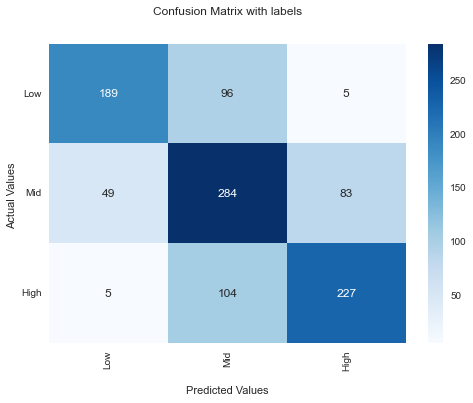

In [100]:
#confusion_matrix
conf_svr_3= confusion_matrix(target_test_3, y_pred_svr_3_round)

ax = sns.heatmap(conf_svr_3, annot=True, cmap='Blues',fmt='g')
ax.set_title('Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')
ax.set_xticklabels(['Low','Mid','High'])
ax.set_yticklabels(['Low','Mid','High'])
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

## SVR - 7 classes

In [106]:
%%time

#Parameters for GridSearchCV

#C - penalty for each error. Low C is low error and the model more generelized. 0.1 < c < 100

#gamma - used only with rbf and means curvature. Low gamma, more generaliztion. Large gamma,  
#points need to be very close to each other, creates overfitting. 0.0001 < gamma < 10

pipe = Pipeline([('over',RandomOverSampler(random_state=12345)), ('scaler',StandardScaler()),('model',SVR())])

param_grid = {'model__C': [0.05, 0.1,1],
              'model__gamma': [1, 0.1, 0.01, 0.001],
              'model__kernel': ['rbf']}

svr = best_model_regression(pipe, param_grid, features_train_mice, target_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END model__C=0.05, model__gamma=1, model__kernel=rbf;, score=(train=-1.499, test=-1.487) total time=   4.4s
[CV 2/5] END model__C=0.05, model__gamma=1, model__kernel=rbf;, score=(train=-1.477, test=-1.578) total time=   3.3s
[CV 3/5] END model__C=0.05, model__gamma=1, model__kernel=rbf;, score=(train=-1.484, test=-1.549) total time=   3.4s
[CV 4/5] END model__C=0.05, model__gamma=1, model__kernel=rbf;, score=(train=-1.484, test=-1.552) total time=   3.5s
[CV 5/5] END model__C=0.05, model__gamma=1, model__kernel=rbf;, score=(train=-1.481, test=-1.569) total time=   3.2s
[CV 1/5] END model__C=0.05, model__gamma=0.1, model__kernel=rbf;, score=(train=-1.500, test=-1.487) total time=   3.6s
[CV 2/5] END model__C=0.05, model__gamma=0.1, model__kernel=rbf;, score=(train=-1.478, test=-1.578) total time=   3.3s
[CV 3/5] END model__C=0.05, model__gamma=0.1, model__kernel=rbf;, score=(train=-1.485, test=-1.550) total time=   3.

In [107]:
y_pred_svr = svr.predict(features_test_mice)

#Create a copy
y_pred_svr_round = np.round(y_pred_svr)

#Make 0 prediction to 1
for i in range(0,len(y_pred_svr_round)):
    if y_pred_svr_round[i]==0:
        y_pred_svr_round[i] = 1
    elif y_pred_svr_round[i]==8:
        y_pred_svr_round[i] = 7
        
print(classification_report(target_test, y_pred_svr_round, target_names=['0','$1-99','$100-999','$1,000-4,999',
                                                               '$5,000-19,999','$20,000-74,999','$75,000 or more']))

                 precision    recall  f1-score   support

              0       0.63      0.29      0.40        83
          $1-99       0.23      0.32      0.27        74
       $100-999       0.34      0.40      0.37       133
   $1,000-4,999       0.35      0.38      0.37       180
  $5,000-19,999       0.37      0.36      0.37       236
 $20,000-74,999       0.32      0.45      0.38       165
$75,000 or more       0.68      0.33      0.44       171

       accuracy                           0.37      1042
      macro avg       0.42      0.36      0.37      1042
   weighted avg       0.42      0.37      0.38      1042



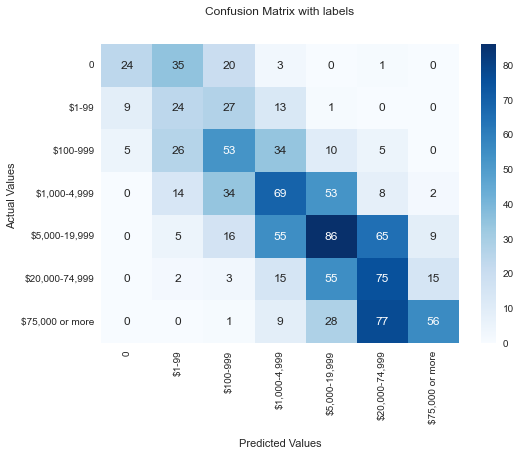

In [108]:
#confusion_matrix
conf_svr= confusion_matrix(target_test, y_pred_svr_round)

ax = sns.heatmap(conf_svr, annot=True, cmap='Blues',fmt='g')
ax.set_title('Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')
ax.set_xticklabels(['0','$1-99','$100-999','$1,000-4,999','$5,000-19,999','$20,000-74,999','$75,000 or more'])
ax.set_yticklabels(['0','$1-99','$100-999','$1,000-4,999','$5,000-19,999','$20,000-74,999','$75,000 or more'])
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

Interstingly we can better predict the class using regression compared to classification, for 7 classes and get to F1 score of 38%

# Final Conclusion

For 7 classes, we could predict savings using SVC with F1 score of 37% and explain the model using LighGBM classifier with F1 score of 34%.

For 3 classes, we could predict savings using SVC with F1 score of 69% and explain the model using Random forest classifier with 68%.

In all feature importance analysis we found that many of psychological factors, mainly those related to self control were hilghly important, and these are the factors that we can also Nudge to make a difference.

Based on this analysis we will plan an experiment.